In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [5]:
data_path = "../data_after_prep"

In [6]:
list_data = os.listdir(data_path)
list_data

['ADRO2001-2407.csv',
 'AMMN2001-2407.csv',
 'AMRT2001-2407.csv',
 'ASII2001-2407.csv',
 'BBCA2001-2407.csv',
 'GOTO2001-2407.csv',
 'KLBF2001-2407.csv',
 'MAPI2001-2407.csv',
 'TLKM2001-2407.csv']

In [7]:
ADRO = pd.read_csv(data_path + "/" + list_data[0], index_col='date', parse_dates=['date'])
AMMN = pd.read_csv(data_path + "/" + list_data[1], index_col='date', parse_dates=['date'])
AMRT = pd.read_csv(data_path + "/" + list_data[2], index_col='date', parse_dates=['date'])
ASII = pd.read_csv(data_path + "/" + list_data[3], index_col='date', parse_dates=['date'])
BBCA = pd.read_csv(data_path + "/" + list_data[4], index_col='date', parse_dates=['date'])
GOTO = pd.read_csv(data_path + "/" + list_data[5], index_col='date', parse_dates=['date'])
KLBF = pd.read_csv(data_path + "/" + list_data[6], index_col='date', parse_dates=['date'])
MAPI = pd.read_csv(data_path + "/" + list_data[7], index_col='date', parse_dates=['date'])
TLKM = pd.read_csv(data_path + "/" + list_data[8], index_col='date', parse_dates=['date'])



In [13]:
#Method
# Some functions to help out with
def plot_predictions(stock_title,test,predicted, title):
    plt.plot(test, color='red',label='Real '+ stock_title+' Stock Price')
    plt.plot(predicted, color='blue',label='Predicted '+ stock_title+' Stock Price')
    plt.title(stock_title + ' Stock Price Prediction '+title)
    plt.xlabel('Time')
    plt.ylabel(stock_title +' Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def return_rmse_norm(test, pred):
    len_pred = len(pred)
    #pred = pred.reshape(len_pred)
    total = np.concatenate((pred, test))
    #total = total.reshape(-1,1)
    total = sc.fit_transform(total)
    arr_pred = total[len_pred:]
    arr_test = total[:len_pred]
    rmse = math.sqrt(mean_squared_error(arr_test, arr_pred))
    print("The root mean squared error after normalization is {}.".format(rmse))
    return rmse

In [31]:
def short_term_train(data, name, start_date, med_date, end_date, epoch, unit, optimizer, batch_size):
    data_short_train = data[start_date:med_date].iloc[:,3:4].values
    data_short_test = data[med_date:end_date].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_short_train)
    len_train = len(data_short_train)
    len_test = len(data_short_test)
    print(len_train, len_test)

    # Since LSTMs store short term memory state, we create a data structure with 5 timesteps and 1 output
    # So for each element of training set, we have 5 previous training set elements 
    X_train = []
    y_train = []
    for i in range(5,len_train):
        X_train.append(training_set_scaled[i-5:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # The LSTM architecture
    regressorLSTM = Sequential()
    # First LSTM layer with Dropout regularisation
    regressorLSTM.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressorLSTM.add(Dropout(0.2))
    # Second LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Third LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Fourth LSTM layer
    regressorLSTM.add(LSTM(units=unit))
    regressorLSTM.add(Dropout(0.2))
    # The output layer
    regressorLSTM.add(Dense(units=1))

    # Compiling the RNN
    regressorLSTM.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set


    regressorLSTM.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)

    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=unit, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)



    # initializing the RNN
    regressorRNN = Sequential()

    # adding first RNN layer and dropout regulatization
    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True, 
                input_shape = (X_train.shape[1],1))
                )

    regressorRNN.add(
        Dropout(0.2)
                )


    # adding second RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding third RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding fourth RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding the output layer
    regressorRNN.add(Dense(units = 1))

    # compiling RNN
    regressorRNN.compile(
        optimizer = optimizer, 
        loss = "mean_squared_error",
        metrics = ["accuracy"])

    # fitting the RNN
    regressorRNN.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)


    dataset_total = pd.concat((data["close"][start_date:med_date],data["close"][med_date:end_date]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_short_test) - 5:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(5,len_test+5):
        X_test.append(inputs[i-5:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
    LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    RNN_predicted_stock_price = regressorRNN.predict(X_test)
    RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)
    # Visualize the data
    # Plot the data
    train = data[start_date:med_date]
    valid = data[med_date:end_date]
    valid['pred_lstm'] = LSTM_predicted_stock_price
    valid['pred_gru'] = GRU_predicted_stock_price
    valid['pred_rnn'] = RNN_predicted_stock_price
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM, GRU, and RNN in ' + name +' Short Term Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
    plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
    plt.savefig('../result_short_tuning/'+name+'short_'+str(optimizer)+'_'+str(batch_size)+'_'+str(epoch)+'_'+str(unit)+'.png')
    # Evaluating the LSTM
    rmse_data_short_LSTM = return_rmse(data_short_test, LSTM_predicted_stock_price)
    norm_rmse_data_short_LSTM = return_rmse_norm(data_short_test, LSTM_predicted_stock_price)
    # Evaluating the RNN
    rmse_data_short_GRU = return_rmse(data_short_test, GRU_predicted_stock_price)
    norm_rmse_data_short_GRU = return_rmse_norm(data_short_test, GRU_predicted_stock_price)
    # Evaluating the sequence
    rmse_data_short_RNN = return_rmse(data_short_test, RNN_predicted_stock_price)
    norm_rmse_data_short_RNN = return_rmse_norm(data_short_test, RNN_predicted_stock_price)
    return(rmse_data_short_LSTM, rmse_data_short_GRU, rmse_data_short_RNN, norm_rmse_data_short_LSTM, norm_rmse_data_short_GRU, norm_rmse_data_short_RNN)



In [15]:
def long_term_train(data, name, year, epoch, unit, optimizer, batch_size):
    data_long_train = data[:year].iloc[:,3:4].values
    data_long_test = data[year:].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_long_train)
    len_train = len(data_long_train)
    len_test = len(data_long_test)
    print(len_train, len_test)

    # Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
    # So for each element of training set, we have 5 previous training set elements 
    X_train = []
    y_train = []
    for i in range(60,len_train):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # The LSTM architecture
    regressorLSTM = Sequential()
    # First LSTM layer with Dropout regularisation
    regressorLSTM.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressorLSTM.add(Dropout(0.2))
    # Second LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Third LSTM layer
    regressorLSTM.add(LSTM(units=unit, return_sequences=True))
    regressorLSTM.add(Dropout(0.2))
    # Fourth LSTM layer
    regressorLSTM.add(LSTM(units=unit))
    regressorLSTM.add(Dropout(0.2))
    # The output layer
    regressorLSTM.add(Dense(units=1))

    # Compiling the RNN
    regressorLSTM.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set


    regressorLSTM.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)

    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=unit, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=unit, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=epoch,batch_size=batch_size)



    # initializing the RNN
    regressorRNN = Sequential()

    # adding first RNN layer and dropout regulatization
    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True, 
                input_shape = (X_train.shape[1],1))
                )

    regressorRNN.add(
        Dropout(0.2)
                )


    # adding second RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding third RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit, 
                activation = "tanh", 
                return_sequences = True)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding fourth RNN layer and dropout regulatization

    regressorRNN.add(
        SimpleRNN(units = unit)
                )

    regressorRNN.add(
        Dropout(0.2)
                )

    # adding the output layer
    regressorRNN.add(Dense(units = 1))

    # compiling RNN
    regressorRNN.compile(
        optimizer = optimizer, 
        loss = "mean_squared_error",
        metrics = ["accuracy"])

    # fitting the RNN
    regressorRNN.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)


    dataset_total = pd.concat((data["close"][:year],data["close"][year:]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_long_test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(60,len_test+60):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
    LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    RNN_predicted_stock_price = regressorRNN.predict(X_test)
    RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

    # Visualize the data
    # Plot the data
    train = data[:year]
    valid = data[year:]
    valid['pred_lstm'] = LSTM_predicted_stock_price
    valid['pred_gru'] = GRU_predicted_stock_price
    valid['pred_rnn'] = RNN_predicted_stock_price
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM, GRU, and RNN in ' + name +' Long Term Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
    plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
    plt.savefig('../result_long_tuning/'+name+'long_'+str(optimizer)+'_'+str(batch_size)+'_'+str(epoch)+'_'+str(unit)+'.png')
    # Evaluating the LSTM
    rmse_data_long_LSTM = return_rmse(data_long_test, LSTM_predicted_stock_price)
    norm_rmse_data_long_LSTM = return_rmse_norm(data_long_test, LSTM_predicted_stock_price)
    # Evaluating the RNN
    rmse_data_long_GRU = return_rmse(data_long_test, GRU_predicted_stock_price)
    norm_rmse_data_long_GRU = return_rmse_norm(data_long_test, GRU_predicted_stock_price)
    # Evaluating the sequence
    rmse_data_long_RNN = return_rmse(data_long_test, RNN_predicted_stock_price)
    norm_rmse_data_long_RNN = return_rmse_norm(data_long_test, RNN_predicted_stock_price)
    return(rmse_data_long_LSTM, rmse_data_long_GRU, rmse_data_long_RNN, norm_rmse_data_long_LSTM, norm_rmse_data_long_GRU, norm_rmse_data_long_RNN)



In [16]:
dic_res = {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : []}

In [17]:
#short term data
start_date = "2024-07-01"
med_date = "2024-07-19"
end_date = "2024-07-31"

#long term data
year = "2023"

## Benchmark Hyperparameter
Architecutre of LSTM, GRU, and RNN used is in this code bechmark from this source:
- LSTM: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook
- GRU: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook
- RNN: https://www.kaggle.com/code/ozkanozturk/stock-price-prediction-by-simple-rnn-and-lstm

### ASII

#### Short Term Predictions

In [11]:
ASII["close"][start_date:med_date].plot(figsize=(16,4), legend=True)
ASII["close"][med_date:end_date].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('ASII Stock Price in July 2024 Split Dataset')
plt.show()

In [12]:
ASII_short_train = ASII[start_date:med_date].iloc[:,3:4].values
ASII_short_test = ASII[med_date:end_date].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ASII_short_train)
len_train = len(ASII_short_train)
len_test = len(ASII_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((ASII["close"][start_date:med_date],ASII["close"][med_date:end_date]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ASII_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(5,len_test+5):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


15 9


Epoch 1/50

1/1 [==============================] - 19s 19s/step - loss: 0.4015
Epoch 2/50
1/1 [==============================] - 0s 98ms/step - loss: 0.3647
Epoch 3/50
1/1 [==============================] - 0s 154ms/step - loss: 0.3354
Epoch 4/50
1/1 [==============================] - 0s 91ms/step - loss: 0.3092
Epoch 5/50
1/1 [==============================] - 0s 89ms/step - loss: 0.2748
Epoch 6/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2368
Epoch 7/50
1/1 [==============================] - 0s 49ms/step - loss: 0.2042
Epoch 8/50
1/1 [==============================] - 0s 38ms/step - loss: 0.1561
Epoch 9/50
1/1 [==============================] - 0s 79ms/step - loss: 0.1383
Epoch 10/50
1/1 [==============================] - 0s 51ms/step - loss: 0.1135
Epoch 11/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0974
Epoch 12/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0640
Epoch 13/50
1/1 [==============================] - 0

In [13]:
# Visualize the data
# Plot the data
train = ASII[start_date:med_date]
valid = ASII[med_date:end_date]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in ASII Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3191275369.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [14]:
# Evaluating the LSTM
rmse_ASII_short_LSTM = return_rmse(ASII_short_test, LSTM_predicted_stock_price)
norm_rmse_ASII_short_LSTM = return_rmse_norm(ASII_short_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_ASII_short_GRU = return_rmse(ASII_short_test, GRU_predicted_stock_price)
norm_rmse_ASII_short_GRU = return_rmse_norm(ASII_short_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_ASII_short_RNN = return_rmse(ASII_short_test, RNN_predicted_stock_price)
norm_rmse_ASII_short_RNN = return_rmse_norm(ASII_short_test, RNN_predicted_stock_price)


The root mean squared error is 55.00948728414271.
The root mean squared error after normalization is 0.39292490917244854.
The root mean squared error is 51.41078512509552.
The root mean squared error after normalization is 0.36721989375068265.
The root mean squared error is 72.92394184766954.
The root mean squared error after normalization is 0.4186496333556479.


In [15]:
#add to the table
#add result LSTM for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_ASII_short_LSTM)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_LSTM)

#add result GRU for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_ASII_short_GRU)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_GRU)

#add result RNN for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_ASII_short_RNN)
dic_res['rmse_norm'].append(norm_rmse_ASII_short_RNN)

In [16]:
dic_res

{'stock': ['ASII', 'ASII', 'ASII'],
 'term': ['short', 'short', 'short'],
 'algorithm': ['LSTM', 'GRU', 'RNN'],
 'rmse': [55.00948728414271, 51.41078512509552, 72.92394184766954],
 'rmse_norm': [0.39292490917244854, 0.36721989375068265, 0.4186496333556479]}

#### Long Term Prediction

In [17]:
ASII["close"][:year].plot(figsize=(16,4), legend=True)
ASII["close"][year:].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Before 2023)","Test set (2023 and Beyond)"])
plt.title('ASII Stock Price in Year 2020 - July 2024 Split Dataset')
plt.show()

In [18]:
ASII_long_train = ASII[:year].iloc[:,3:4].values
ASII_long_test = ASII[year:].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ASII_long_train)
len_train = len(ASII_long_train)
len_test = len(ASII_long_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((ASII["close"][:year],ASII["close"][year:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(ASII_long_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len_test+60):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


974 372
Epoch 1/50
29/29 [==============================] - 29s 141ms/step - loss: 0.0495
Epoch 2/50
29/29 [==============================] - 4s 129ms/step - loss: 0.0213
Epoch 3/50
29/29 [==============================] - 5s 189ms/step - loss: 0.0181
Epoch 4/50
29/29 [==============================] - 5s 180ms/step - loss: 0.0178
Epoch 5/50
29/29 [==============================] - 6s 220ms/step - loss: 0.0132
Epoch 6/50
29/29 [==============================] - 4s 155ms/step - loss: 0.0170
Epoch 7/50
29/29 [==============================] - 4s 121ms/step - loss: 0.0123
Epoch 8/50
29/29 [==============================] - 4s 154ms/step - loss: 0.0127
Epoch 9/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0120
Epoch 10/50
29/29 [==============================] - 8s 282ms/step - loss: 0.0118
Epoch 11/50
29/29 [==============================] - 4s 132ms/step - loss: 0.0108
Epoch 12/50
29/29 [==============================] - 4s 126ms/step - loss: 0.0093
Epoch 13/50
29/2

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\2420081142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

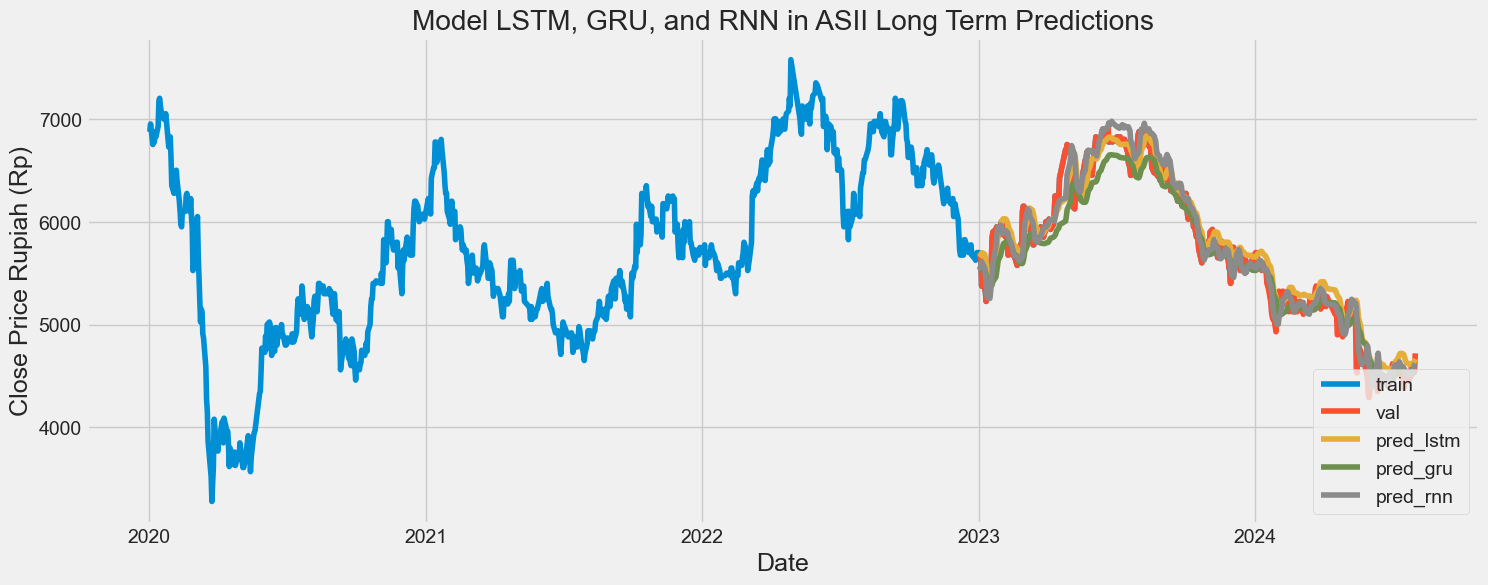

In [19]:
# Visualize the data
# Plot the data
train = ASII[:year]
valid = ASII[year:]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in ASII Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


In [20]:
# Evaluating the LSTM
rmse_ASII_long_LSTM = return_rmse(ASII_long_test, LSTM_predicted_stock_price)
norm_rmse_ASII_long_LSTM = return_rmse_norm(ASII_long_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_ASII_long_GRU = return_rmse(ASII_long_test, GRU_predicted_stock_price)
norm_rmse_ASII_long_GRU = return_rmse_norm(ASII_long_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_ASII_long_RNN = return_rmse(ASII_long_test, RNN_predicted_stock_price)
norm_rmse_ASII_long_RNN = return_rmse_norm(ASII_long_test, RNN_predicted_stock_price)


The root mean squared error is 197.5755217333279.
The root mean squared error after normalization is 0.07762084459241526.
The root mean squared error is 167.37215284412167.
The root mean squared error after normalization is 0.06602451788722748.
The root mean squared error is 163.07260452597404.
The root mean squared error after normalization is 0.06070873133266466.


In [21]:
#add to the table
#add result LSTM for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_ASII_long_LSTM)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_LSTM)

#add result GRU for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_ASII_long_GRU)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_GRU)

#add result RNN for ASII
dic_res['stock'].append('ASII')
dic_res['term'].append('long')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_ASII_long_RNN)
dic_res['rmse_norm'].append(norm_rmse_ASII_long_RNN)

### GOTO

#### Short Term Predictions

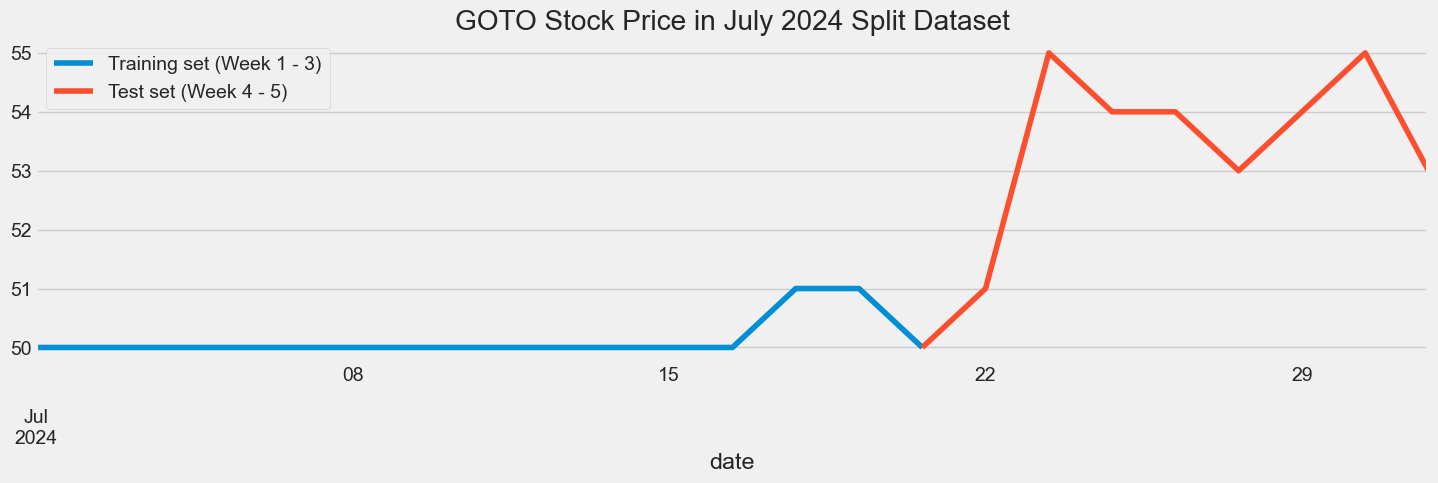

In [22]:
GOTO["close"][start_date:med_date].plot(figsize=(16,4), legend=True)
GOTO["close"][med_date:end_date].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Week 1 - 3)","Test set (Week 4 - 5)"])
plt.title('GOTO Stock Price in July 2024 Split Dataset')
plt.show()

In [23]:
GOTO_short_train = GOTO[start_date:med_date].iloc[:,3:4].values
GOTO_short_test = GOTO[med_date:end_date].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(GOTO_short_train)
len_train = len(GOTO_short_train)
len_test = len(GOTO_short_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 
X_train = []
y_train = []
for i in range(5,len_train):
    X_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((GOTO["close"][start_date:med_date],GOTO["close"][med_date:end_date]),axis=0)
inputs = dataset_total[len(dataset_total)-len(GOTO_short_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(5,len_test+5):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


15 9
Epoch 1/50
1/1 [==============================] - 19s 19s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 11/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 12/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 13

In [24]:
# Visualize the data
# Plot the data
train = GOTO[start_date:med_date]
valid = GOTO[med_date:end_date]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in GOTO Short Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\3190838348.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [25]:
# Evaluating the LSTM
rmse_GOTO_short_LSTM = return_rmse(GOTO_short_test, LSTM_predicted_stock_price)
norm_rmse_GOTO_short_LSTM = return_rmse_norm(GOTO_short_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_GOTO_short_GRU = return_rmse(GOTO_short_test, GRU_predicted_stock_price)
norm_rmse_GOTO_short_GRU = return_rmse_norm(GOTO_short_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_GOTO_short_RNN = return_rmse(GOTO_short_test, RNN_predicted_stock_price)
norm_rmse_GOTO_short_RNN = return_rmse_norm(GOTO_short_test, RNN_predicted_stock_price)


The root mean squared error is 2.3485607668839226.
The root mean squared error after normalization is 0.7828535889613071.
The root mean squared error is 2.3901321579925154.
The root mean squared error after normalization is 0.7785089621701156.
The root mean squared error is 2.2216644652497815.
The root mean squared error after normalization is 0.5773929000990808.


In [26]:
#add to the table
#add result LSTM for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_GOTO_short_LSTM)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_LSTM)

#add result GRU for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_GOTO_short_GRU)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_GRU)

#add result RNN for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('short')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_GOTO_short_RNN)
dic_res['rmse_norm'].append(norm_rmse_GOTO_short_RNN)

#### Long Term Predictions

In [27]:
GOTO["close"][:year].plot(figsize=(16,4), legend=True)
GOTO["close"][year:].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (Before 2023)","Test set (2023 and Beyond)"])
plt.title('GOTO Stock Price in Year 2020 - July 2024 Split Dataset')
plt.show()

In [28]:
GOTO_long_train = GOTO[:year].iloc[:,3:4].values
GOTO_long_test = GOTO[year:].iloc[:,3:4].values

#Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(GOTO_long_train)
len_train = len(GOTO_long_train)
len_test = len(GOTO_long_test)
print(len_train, len_test)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len_train):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))

# Compiling the RNN
regressorLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set


regressorLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)



# initializing the RNN
regressorRNN = Sequential()

# adding first RNN layer and dropout regulatization
regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressorRNN.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressorRNN.add(
    SimpleRNN(units = 50)
             )

regressorRNN.add(
    Dropout(0.2)
             )

# adding the output layer
regressorRNN.add(Dense(units = 1))

# compiling RNN
regressorRNN.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
regressorRNN.fit(X_train, y_train, epochs = 50, batch_size = 32)


dataset_total = pd.concat((GOTO["close"][:year],GOTO["close"][year:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(GOTO_long_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len_test+60):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)


418 372
Epoch 1/50
12/12 [==============================] - 16s 97ms/step - loss: 0.0213
Epoch 2/50
12/12 [==============================] - 1s 112ms/step - loss: 0.0103
Epoch 3/50
12/12 [==============================] - 1s 115ms/step - loss: 0.0066
Epoch 4/50
12/12 [==============================] - 1s 111ms/step - loss: 0.0098
Epoch 5/50
12/12 [==============================] - 2s 153ms/step - loss: 0.0093
Epoch 6/50
12/12 [==============================] - 2s 193ms/step - loss: 0.0064
Epoch 7/50
12/12 [==============================] - 2s 126ms/step - loss: 0.0076
Epoch 8/50
12/12 [==============================] - 1s 121ms/step - loss: 0.0059
Epoch 9/50
12/12 [==============================] - 2s 156ms/step - loss: 0.0071
Epoch 10/50
12/12 [==============================] - 4s 301ms/step - loss: 0.0045
Epoch 11/50
12/12 [==============================] - 2s 205ms/step - loss: 0.0053
Epoch 12/50
12/12 [==============================] - 1s 104ms/step - loss: 0.0071
Epoch 13/50
12/12

In [29]:
# Visualize the data
# Plot the data
train = GOTO[:year]
valid = GOTO[year:]
valid['pred_lstm'] = LSTM_predicted_stock_price
valid['pred_gru'] = GRU_predicted_stock_price
valid['pred_rnn'] = RNN_predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model LSTM, GRU, and RNN in GOTO Long Term Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid['close'])
plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
plt.show()


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19064\1645492680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [30]:
# Evaluating the LSTM
rmse_GOTO_long_LSTM = return_rmse(GOTO_long_test, LSTM_predicted_stock_price)
norm_rmse_GOTO_long_LSTM = return_rmse_norm(GOTO_long_test, LSTM_predicted_stock_price)
# Evaluating the RNN
rmse_GOTO_long_GRU = return_rmse(GOTO_long_test, GRU_predicted_stock_price)
norm_rmse_GOTO_long_GRU = return_rmse_norm(GOTO_long_test, GRU_predicted_stock_price)
# Evaluating the sequence
rmse_GOTO_long_RNN = return_rmse(GOTO_long_test, RNN_predicted_stock_price)
norm_rmse_GOTO_long_RNN = return_rmse_norm(GOTO_long_test, RNN_predicted_stock_price)


The root mean squared error is 10.179641512203748.
The root mean squared error after normalization is 0.13050822451543267.
The root mean squared error is 7.381589976016897.
The root mean squared error after normalization is 0.09463576892329355.
The root mean squared error is 8.10699611494832.
The root mean squared error after normalization is 0.08033623230537396.


In [31]:
#add to the table
#add result LSTM for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('LSTM')
dic_res['rmse'].append(rmse_GOTO_long_LSTM)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_LSTM)

#add result GRU for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('GRU')
dic_res['rmse'].append(rmse_GOTO_long_GRU)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_GRU)

#add result RNN for GOTO
dic_res['stock'].append('GOTO')
dic_res['term'].append('long')
dic_res['algorithm'].append('RNN')
dic_res['rmse'].append(rmse_GOTO_long_RNN)
dic_res['rmse_norm'].append(norm_rmse_GOTO_long_RNN)

In [32]:
res = pd.DataFrame(dic_res)

In [45]:
res['epoch'] = 50
res['unit'] = 50
res['optimizer'] = ['rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam', 'rmsprop', 'sgd', 'adam']
res['batch_size'] = [32, 150, 32, 32, 150, 32, 32, 150, 32, 32, 150, 32]

In [46]:
res

stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0   ASII  short      LSTM   55.009487   0.392925     50    50   rmsprop   
1   ASII  short       GRU   51.410785   0.367220     50    50       sgd   
2   ASII  short       RNN   72.923942   0.418650     50    50      adam   
3   ASII   long      LSTM  197.575522   0.077621     50    50   rmsprop   
4   ASII   long       GRU  167.372153   0.066025     50    50       sgd   
5   ASII   long       RNN  163.072605   0.060709     50    50      adam   
6   GOTO  short      LSTM    2.348561   0.782854     50    50   rmsprop   
7   GOTO  short       GRU    2.390132   0.778509     50    50       sgd   
8   GOTO  short       RNN    2.221664   0.577393     50    50      adam   
9   GOTO   long      LSTM   10.179642   0.130508     50    50   rmsprop   
10  GOTO   long       GRU    7.381590   0.094636     50    50       sgd   
11  GOTO   long       RNN    8.106996   0.080336     50    50      adam   

    batch_size  
0           32  
1          150  
2           32  
3           32  
4          150  
5           32  
6           32  
7          150  
8           32  
9           32  
10         150  
11          32

In [47]:
res.to_csv('../result/goto-asii-long-short-baseline.csv')

## Tuning Hyperparameter
- optimizer = SGD, Adam, RMSProp
- epoch = 50, 100
- batch size =  32, 64, 128
- unit = 50, 100


#### Short Term Predictions

In [18]:
dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}

In [30]:
def train_short(data, name, start_date, med_date, end_date, epoch, unit, batch_size, optimizer):
    rmse_LSTM, rmse_GRU, rmse_RNN, rmse_norm_LSTM, rmse_norm_GRU, rmse_norm_RNN =  short_term_train(data=data, name=name, start_date=start_date, med_date=med_date, end_date=end_date, epoch=epoch, unit=unit, batch_size=batch_size, optimizer= optimizer) 
    dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}
    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)

    dic_res_tuning['algorithm'].append('LSTM')
    dic_res_tuning['rmse'].append(rmse_LSTM)
    dic_res_tuning['rmse_norm'].append(rmse_norm_LSTM)

    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)

    dic_res_tuning['algorithm'].append('GRU')
    dic_res_tuning['rmse'].append(rmse_GRU)
    dic_res_tuning['rmse_norm'].append(rmse_norm_GRU)


    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)
    
    dic_res_tuning['algorithm'].append('RNN')
    dic_res_tuning['rmse'].append(rmse_RNN)
    dic_res_tuning['rmse_norm'].append(rmse_norm_RNN)
    
    # Make data frame of above data
    df = pd.DataFrame(dic_res_tuning)
    # append data frame to CSV file
    df.to_csv('../result_short_tuning/result_short_tuning.csv', mode='a', header=False, index=False)
 



In [29]:
def train_long(data, name, year, epoch, unit, batch_size, optimizer):
    rmse_LSTM, rmse_GRU, rmse_RNN, rmse_norm_LSTM, rmse_norm_GRU, rmse_norm_RNN =  long_term_train(data=data, name=name, year=year, epoch=epoch, unit=unit, batch_size=batch_size, optimizer=optimizer) 
    dic_res_tuning =  {'stock' : [], 'term' : [], 'algorithm': [], 'rmse' : [], 'rmse_norm' : [], 'epoch' : [], 'unit': [], 'optimizer' : [], 'batch_size' : []}
    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)

    dic_res_tuning['algorithm'].append('LSTM')
    dic_res_tuning['rmse'].append(rmse_LSTM)
    dic_res_tuning['rmse_norm'].append(rmse_norm_LSTM)

    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)

    dic_res_tuning['algorithm'].append('GRU')
    dic_res_tuning['rmse'].append(rmse_GRU)
    dic_res_tuning['rmse_norm'].append(rmse_norm_GRU)


    dic_res_tuning['stock'].append(name)
    dic_res_tuning['term'].append('short')
    dic_res_tuning['epoch'].append(epoch)
    dic_res_tuning['unit'].append(unit)
    dic_res_tuning['optimizer'].append(optimizer)
    dic_res_tuning['batch_size'].append(batch_size)
    
    dic_res_tuning['algorithm'].append('RNN')
    dic_res_tuning['rmse'].append(rmse_RNN)
    dic_res_tuning['rmse_norm'].append(rmse_norm_RNN)
    
    # Make data frame of above data
    df = pd.DataFrame(dic_res_tuning)
    # append data frame to CSV file
    df.to_csv('../result_long_tuning/result_long_tuning.csv', mode='a')
 



15 9
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.4021
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3562
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3141
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2779
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2419
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2070
Epoch 7/50
1/1 [==============================] - 0s 94ms/step - loss: 0.1733
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 0.1371
Epoch 9/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0805
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1222
Epoch 11/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0755
Epoch 12/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0887
Epoch 13/50
1/1 [==============================] - 0s 18

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 56.828388723594095.
The root mean squared error after normalization is 0.4059170623113868.
The root mean squared error is 46.53015914405754.
The root mean squared error after normalization is 0.33235827960041114.
The root mean squared error is 68.82359938131098.
The root mean squared error after normalization is 0.4394246560781047.
15 9
Epoch 1/50
1/1 [==============================] - 22s 22s/step - loss: 0.3943
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3769
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3633
Epoch 4/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3415
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 0.3216
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3018
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2815
Epoch 8/50
1/1 [==============================] - 0s 33ms/step - loss: 0.2583
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.55799091288563.
The root mean squared error after normalization is 0.3896999350920406.
The root mean squared error is 47.977016435024616.
The root mean squared error after normalization is 0.3426929745358893.
The root mean squared error is 72.28648696760688.
The root mean squared error after normalization is 0.5126026651442803.
15 9
Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 0.4022
Epoch 2/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3722
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3470
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 0.3231
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3034
Epoch 6/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2797
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2666
Epoch 8/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2460
Epoch 9

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 58.05362093805937.
The root mean squared error after normalization is 0.4146687209861379.
The root mean squared error is 53.95883014970645.
The root mean squared error after normalization is 0.38542021535504695.
The root mean squared error is 53.65086796094897.
The root mean squared error after normalization is 0.38322048543535014.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.4034
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3655
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3332
Epoch 4/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3022
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2705
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2308
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 0.1964
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1633
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.183867842647054.
The root mean squared error after normalization is 0.37988477030462137.
The root mean squared error is 53.16851782590568.
The root mean squared error after normalization is 0.3797751273278978.
The root mean squared error is 90.16772346735165.
The root mean squared error after normalization is 0.3780594116116786.
15 9
Epoch 1/50
1/1 [==============================] - 26s 26s/step - loss: 0.3948
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3791
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3618
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3424
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.3210
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3075
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2759
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2530
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 55.015273071654214.
The root mean squared error after normalization is 0.3929662362261011.
The root mean squared error is 53.40025031506959.
The root mean squared error after normalization is 0.38143035939335385.
The root mean squared error is 85.32479693511594.
The root mean squared error after normalization is 0.4386956112236805.
15 9
Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.4009
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3751
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3533
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3335
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3112
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2936
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2755
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2618
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 59.942256505614935.
The root mean squared error after normalization is 0.4281589750401069.
The root mean squared error is 53.76252755594532.
The root mean squared error after normalization is 0.3840180539710385.
The root mean squared error is 62.89046201085886.
The root mean squared error after normalization is 0.4492175857918494.
15 9
Epoch 1/50
1/1 [==============================] - 27s 27s/step - loss: 0.3988
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.3434
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.2990
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2466
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1875
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1307
Epoch 7/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0857
Epoch 8/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0761
Epoch 9

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 52.010162151958504.
The root mean squared error after normalization is 0.37150115822827534.
The root mean squared error is 56.25930423951666.
The root mean squared error after normalization is 0.4018521731394055.
The root mean squared error is 92.02649839692606.
The root mean squared error after normalization is 0.5358546701113809.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.3980
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3734
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3502
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3205
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2853
Epoch 6/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2468
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 0.2051
Epoch 8/50
1/1 [==============================] - 0s 29ms/step - loss: 0.1594
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.75947609792956.
The root mean squared error after normalization is 0.38399625784235325.
The root mean squared error is 49.914074918313815.
The root mean squared error after normalization is 0.3565291065593852.
The root mean squared error is 84.05364101342428.
The root mean squared error after normalization is 0.4346819003062817.
15 9
Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 0.3997
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3717
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3431
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3190
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2994
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2783
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2595
Epoch 8/50
1/1 [==============================] - 0s 29ms/step - loss: 0.2438
Epoch 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 57.393970300031306.
The root mean squared error after normalization is 0.4099569307145091.
The root mean squared error is 53.67834390928978.
The root mean squared error after normalization is 0.38341674220921323.
The root mean squared error is 58.00673992200035.
The root mean squared error after normalization is 0.414333856585716.
15 9
Epoch 1/50
1/1 [==============================] - 47s 47s/step - loss: 0.4040
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3387
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2807
Epoch 4/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2216
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1408
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1079
Epoch 7/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0823
Epoch 8/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0859
Epoch 9

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.01003810202439.
The root mean squared error after normalization is 0.37864312930017363.
The root mean squared error is 49.805747059573704.
The root mean squared error after normalization is 0.355755336139812.
The root mean squared error is 164.46261614169723.
The root mean squared error after normalization is 0.5980331346956314.
15 9
Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.4029
Epoch 2/50
1/1 [==============================] - 0s 117ms/step - loss: 0.3770
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3487
Epoch 4/50
1/1 [==============================] - 0s 60ms/step - loss: 0.3215
Epoch 5/50
1/1 [==============================] - 0s 66ms/step - loss: 0.2879
Epoch 6/50
1/1 [==============================] - 0s 31ms/step - loss: 0.2443
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 0.1983
Epoch 8/50
1/1 [==============================] - 0s 55ms/step - loss: 0.1599
Epoch

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.895667728473896.
The root mean squared error after normalization is 0.3849690552033845.
The root mean squared error is 47.814396083859.
The root mean squared error after normalization is 0.34153140059899373.
The root mean squared error is 57.79229256814257.
The root mean squared error after normalization is 0.4128020897724477.
15 9
Epoch 1/50
1/1 [==============================] - 42s 42s/step - loss: 0.4039
Epoch 2/50
1/1 [==============================] - 0s 42ms/step - loss: 0.3753
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 0.3493
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.3250
Epoch 5/50
1/1 [==============================] - 0s 38ms/step - loss: 0.3047
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 0.2885
Epoch 7/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2695
Epoch 8/50
1/1 [==============================] - 0s 44ms/step - loss: 0.2554
Epoch 9/

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 58.32071727383115.
The root mean squared error after normalization is 0.41657655195593696.
The root mean squared error is 53.002683013805886.
The root mean squared error after normalization is 0.3785905929557565.
The root mean squared error is 55.68670042177257.
The root mean squared error after normalization is 0.39776214586980496.
15 9
Epoch 1/100
1/1 [==============================] - 31s 31s/step - loss: 0.4080
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 0.3658
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3383
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.3011
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2798
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2406
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1973
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 0.17

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 55.855092044417894.
The root mean squared error after normalization is 0.3989649431744145.
The root mean squared error is 45.77585544968592.
The root mean squared error after normalization is 0.3269703960691862.
The root mean squared error is 97.94218449214571.
The root mean squared error after normalization is 0.5391462649207605.
15 9
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.3987
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.3819
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.3639
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.3444
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.3315
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 0.3113
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.2868
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 0.2649

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.30337863481961.
The root mean squared error after normalization is 0.3878812759629979.
The root mean squared error is 47.23798905513954.
The root mean squared error after normalization is 0.33741420753671214.
The root mean squared error is 60.46771411013937.
The root mean squared error after normalization is 0.43191224364385394.
15 9
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.4015
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3734
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3502
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3289
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3057
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.2868
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2714
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.254

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.422151821923286.
The root mean squared error after normalization is 0.38872965587088143.
The root mean squared error is 53.575161718918665.
The root mean squared error after normalization is 0.38267972656370414.
The root mean squared error is 45.19771843560724.
The root mean squared error after normalization is 0.32284084596862184.
15 9
Epoch 1/100
1/1 [==============================] - 25s 25s/step - loss: 0.4009
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3573
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3209
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2910
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2465
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2102
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1601
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 0.

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 56.168004762150275.
The root mean squared error after normalization is 0.4012000340153602.
The root mean squared error is 44.1225118824121.
The root mean squared error after normalization is 0.3151607991600875.
The root mean squared error is 81.17538203639808.
The root mean squared error after normalization is 0.4418764649563922.
15 9
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.3994
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.3827
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3636
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3460
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3239
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3018
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.2762
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.2572


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.89291805269234.
The root mean squared error after normalization is 0.3920922718049451.
The root mean squared error is 50.038278839039215.
The root mean squared error after normalization is 0.35741627742170823.
The root mean squared error is 63.359749293917055.
The root mean squared error after normalization is 0.4525696378136931.
15 9
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.3978
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.3688
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.3408
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3143
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2929
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2686
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2577
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.23

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.19061624380143.
The root mean squared error after normalization is 0.3870758303128679.
The root mean squared error is 54.49890575831843.
The root mean squared error after normalization is 0.3892778982737034.
The root mean squared error is 61.22174601514861.
The root mean squared error after normalization is 0.43729818582249064.
15 9
Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 0.3990
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.3413
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2900
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2312
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1773
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1274
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1011
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0855

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 50.869946365222766.
The root mean squared error after normalization is 0.36335675975159126.
The root mean squared error is 41.49759515850712.
The root mean squared error after normalization is 0.2964113939893359.
The root mean squared error is 87.75265024596058.
The root mean squared error after normalization is 0.5582985744224247.
15 9
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.3973
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 0.3687
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3412
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.3080
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2710
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2311
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1797
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 0.136

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.26451885832567.
The root mean squared error after normalization is 0.3876037061308983.
The root mean squared error is 40.94964361451032.
The root mean squared error after normalization is 0.29249745438936.
The root mean squared error is 89.91645421373372.
The root mean squared error after normalization is 0.5162700999737211.
15 9
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.4064
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3792
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3535
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 0.3321
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.3078
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2885
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2709
Epoch 8/100
1/1 [==============================] - 0s 55ms/step - loss: 0.2548
Ep

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.39548262112096.
The root mean squared error after normalization is 0.38853916157943547.
The root mean squared error is 53.59406282873023.
The root mean squared error after normalization is 0.38281473449093023.
The root mean squared error is 63.14955079154744.
The root mean squared error after normalization is 0.45106821993962426.
15 9
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.3969
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.3435
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2952
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2402
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1737
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1134
Epoch 7/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0933
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 0.09

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 52.260589625935566.
The root mean squared error after normalization is 0.3732899258995389.
The root mean squared error is 41.55710860764776.
The root mean squared error after normalization is 0.2968364900546271.
The root mean squared error is 116.7934308418397.
The root mean squared error after normalization is 0.5044795953163168.
15 9
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.3997
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 0.3743
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.3467
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.3161
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2890
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2528
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2010
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1626

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 53.49808282922804.
The root mean squared error after normalization is 0.3821291630659156.
The root mean squared error is 42.12620209419784.
The root mean squared error after normalization is 0.3009014435299844.
The root mean squared error is 57.42715078255701.
The root mean squared error after normalization is 0.41019393416112304.
15 9
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.4000
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3720
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.3465
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.3238
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3014
Epoch 6/100
1/1 [==============================] - 0s 30ms/step - loss: 0.2817
Epoch 7/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2640
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2515

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 54.45530050083239.
The root mean squared error after normalization is 0.3889664321488028.
The root mean squared error is 53.88431087121042.
The root mean squared error after normalization is 0.38488793479436023.
The root mean squared error is 74.77575608203571.
The root mean squared error after normalization is 0.5165280353749788.
15 9
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 27ms

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3568989197129167.
The root mean squared error after normalization is 0.7855290926406711.
The root mean squared error is 2.378767399544572.
The root mean squared error after normalization is 0.7821906585445616.
The root mean squared error is 2.4106660387301253.
The root mean squared error after normalization is 0.6752198546400223.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.355809124722939.
The root mean squared error after normalization is 0.7852697082409785.
The root mean squared error is 2.3664971260071916.
The root mean squared error after normalization is 0.7844444926919014.
The root mean squared error is 2.426297587998415.
The root mean squared error after normalization is 0.562037059374531.
15 9
Epoch 1/50
1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 25ms/

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3601267459104216.
The root mean squared error after normalization is 0.7849562105486779.
The root mean squared error is 2.2870799853152084.
The root mean squared error after normalization is 0.7623599951050689.
The root mean squared error is 2.5148125713569587.
The root mean squared error after normalization is 0.7107036571098053.
15 9
Epoch 1/50
1/1 [==============================] - 14s 14s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 22

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3503977404299903.
The root mean squared error after normalization is 0.7834659134766627.
The root mean squared error is 2.3037591163260074.
The root mean squared error after normalization is 0.7679197054420015.
The root mean squared error is 1.7223805531830656.
The root mean squared error after normalization is 0.5741268510610211.
15 9
Epoch 1/50
1/1 [==============================] - 26s 26s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 24

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3522496396966934.
The root mean squared error after normalization is 0.7840832132322303.
The root mean squared error is 2.3198178972188357.
The root mean squared error after normalization is 0.7732726324062775.
The root mean squared error is 2.3347930872053837.
The root mean squared error after normalization is 0.708530467176373.
15 9
Epoch 1/50
1/1 [==============================] - 27s 27s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 37m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3498517476831395.
The root mean squared error after normalization is 0.7832839158943788.
The root mean squared error is 2.347781578069751.
The root mean squared error after normalization is 0.7825938593565838.
The root mean squared error is 2.5271492588244215.
The root mean squared error after normalization is 0.6947910523594552.
15 9
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 59ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 59ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 25m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.367603435938264.
The root mean squared error after normalization is 0.783305675275983.
The root mean squared error is 2.412561816892362.
The root mean squared error after normalization is 0.7760906573266153.
The root mean squared error is 2.5906857882312684.
The root mean squared error after normalization is 0.674683869832423.
15 9
Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 19ms/s

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.358288402208427.
The root mean squared error after normalization is 0.7853501616640255.
The root mean squared error is 2.4186426694135297.
The root mean squared error after normalization is 0.7773313699952568.
The root mean squared error is 2.8658112173996666.
The root mean squared error after normalization is 0.7081247533000209.
15 9
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 29m

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.354894068774862.
The root mean squared error after normalization is 0.7849167820731834.
The root mean squared error is 2.3661670760807034.
The root mean squared error after normalization is 0.7822371366641356.
The root mean squared error is 3.460395407153776.
The root mean squared error after normalization is 0.7267865318296292.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 27ms

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3532435273796697.
The root mean squared error after normalization is 0.7844145091265562.
The root mean squared error is 2.3766973153865703.
The root mean squared error after normalization is 0.7818865830252788.
The root mean squared error is 2.3476401591405467.
The root mean squared error after normalization is 0.6844393281697002.
15 9
Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 29

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.363274397175912.
The root mean squared error after normalization is 0.7841426877182218.
The root mean squared error is 2.487371421783119.
The root mean squared error after normalization is 0.7713677417580098.
The root mean squared error is 3.557749071325099.
The root mean squared error after normalization is 0.7517237211393871.
15 9
Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 18ms/

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.361377221913532.
The root mean squared error after normalization is 0.7845857178036673.
The root mean squared error is 2.3379791189908063.
The root mean squared error after normalization is 0.7793263729969345.
The root mean squared error is 2.3268009827892.
The root mean squared error after normalization is 0.7166874444319938.
15 9
Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3710447472176903.
The root mean squared error after normalization is 0.7821206035127931.
The root mean squared error is 2.4103532781028307.
The root mean squared error after normalization is 0.7772352935022335.
The root mean squared error is 1.943884116085416.
The root mean squared error after normalization is 0.5587877606571264.
15 9
Epoch 1/100
1/1 [==============================] - 27s 27s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3513395012937686.
The root mean squared error after normalization is 0.7837798337645888.
The root mean squared error is 2.295377813947946.
The root mean squared error after normalization is 0.7651259379826478.
The root mean squared error is 2.9374385111310284.
The root mean squared error after normalization is 0.6902617786161562.
15 9
Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3588532100107997.
The root mean squared error after normalization is 0.7852350030223767.
The root mean squared error is 2.344414003664803.
The root mean squared error after normalization is 0.781471334554933.
The root mean squared error is 2.040414044813765.
The root mean squared error after normalization is 0.6137032801496844.
15 9
Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3502467740842707.
The root mean squared error after normalization is 0.7834155913614224.
The root mean squared error is 2.448395732941205.
The root mean squared error after normalization is 0.7731083718878048.
The root mean squared error is 2.078167207623187.
The root mean squared error after normalization is 0.6551077211105659.
15 9
Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3652741398349035.
The root mean squared error after normalization is 0.7836625427514042.
The root mean squared error is 2.3085010737418084.
The root mean squared error after normalization is 0.7695003579139351.
The root mean squared error is 2.69910787322722.
The root mean squared error after normalization is 0.7432666679124665.
15 9
Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 67ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3516000480834354.
The root mean squared error after normalization is 0.7838666826944778.
The root mean squared error is 2.333697463253058.
The root mean squared error after normalization is 0.7778991544176852.
The root mean squared error is 2.542353973236422.
The root mean squared error after normalization is 0.6936389191744229.
15 9
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3524359071909284.
The root mean squared error after normalization is 0.7841453023969749.
The root mean squared error is 2.3426911175301575.
The root mean squared error after normalization is 0.7808970391767186.
The root mean squared error is 1.9933790115391157.
The root mean squared error after normalization is 0.6294537341850194.
15 9
Epoch 1/100
1/1 [==============================] - 26s 26s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================]

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3658613829712585.
The root mean squared error after normalization is 0.7837194242466891.
The root mean squared error is 2.3711078327205555.
The root mean squared error after normalization is 0.7841078370211341.
The root mean squared error is 1.8135799382490845.
The root mean squared error after normalization is 0.5696964568944629.
15 9
Epoch 1/100
1/1 [==============================] - 26s 26s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================]

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.358536186761696.
The root mean squared error after normalization is 0.7854167139558266.
The root mean squared error is 2.439119592946802.
The root mean squared error after normalization is 0.7746206755614853.
The root mean squared error is 3.2063354166460107.
The root mean squared error after normalization is 0.7852817332196484.
15 9
Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.361053731208534.
The root mean squared error after normalization is 0.7845906071557621.
The root mean squared error is 2.409484087846494.
The root mean squared error after normalization is 0.7776992744520067.
The root mean squared error is 2.563783295272127.
The root mean squared error after normalization is 0.6212009447740939.
15 9
Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 80ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================] -

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3567151087939955.
The root mean squared error after normalization is 0.7855367427745777.
The root mean squared error is 2.3290195889377205.
The root mean squared error after normalization is 0.7763398629792393.
The root mean squared error is 2.2353696012209903.
The root mean squared error after normalization is 0.7301794565696557.
15 9
Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 8/100
1/1 [==============================]

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12928\8162379.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

The root mean squared error is 2.3549079832600737.
The root mean squared error after normalization is 0.7849693277533573.
The root mean squared error is 2.267225662700026.
The root mean squared error after normalization is 0.7557418875666743.
The root mean squared error is 2.446301962548625.
The root mean squared error after normalization is 0.7086936090716314.


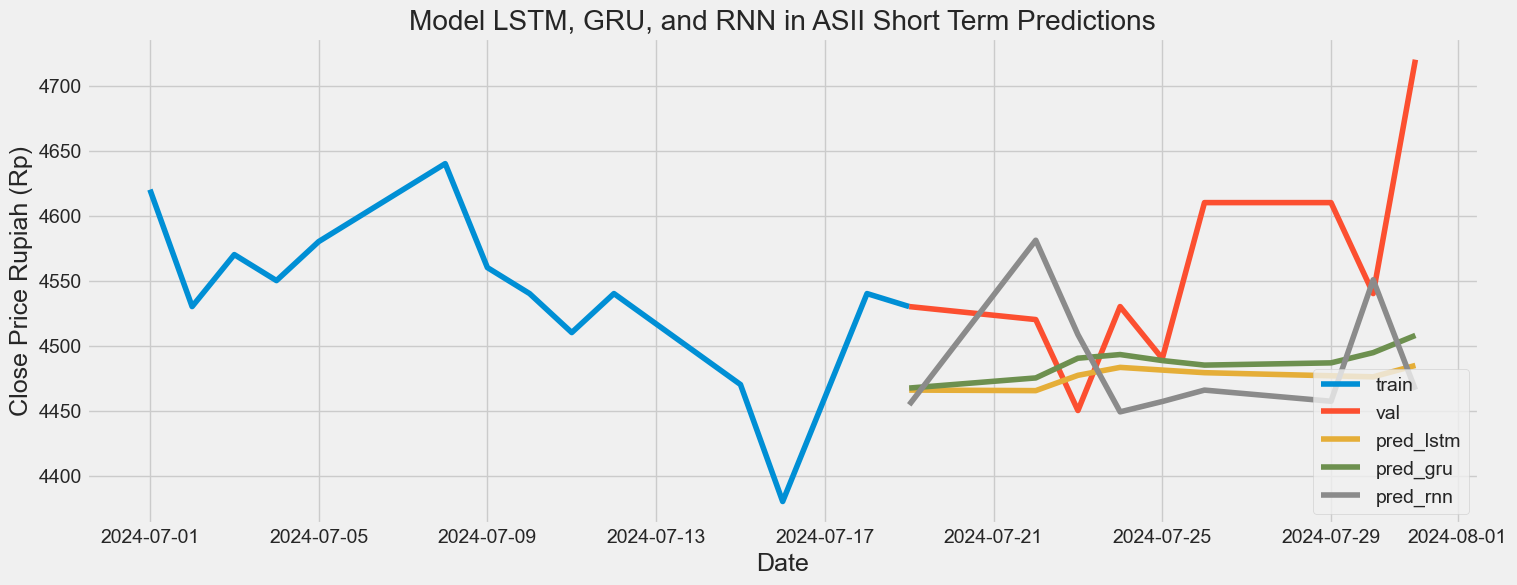

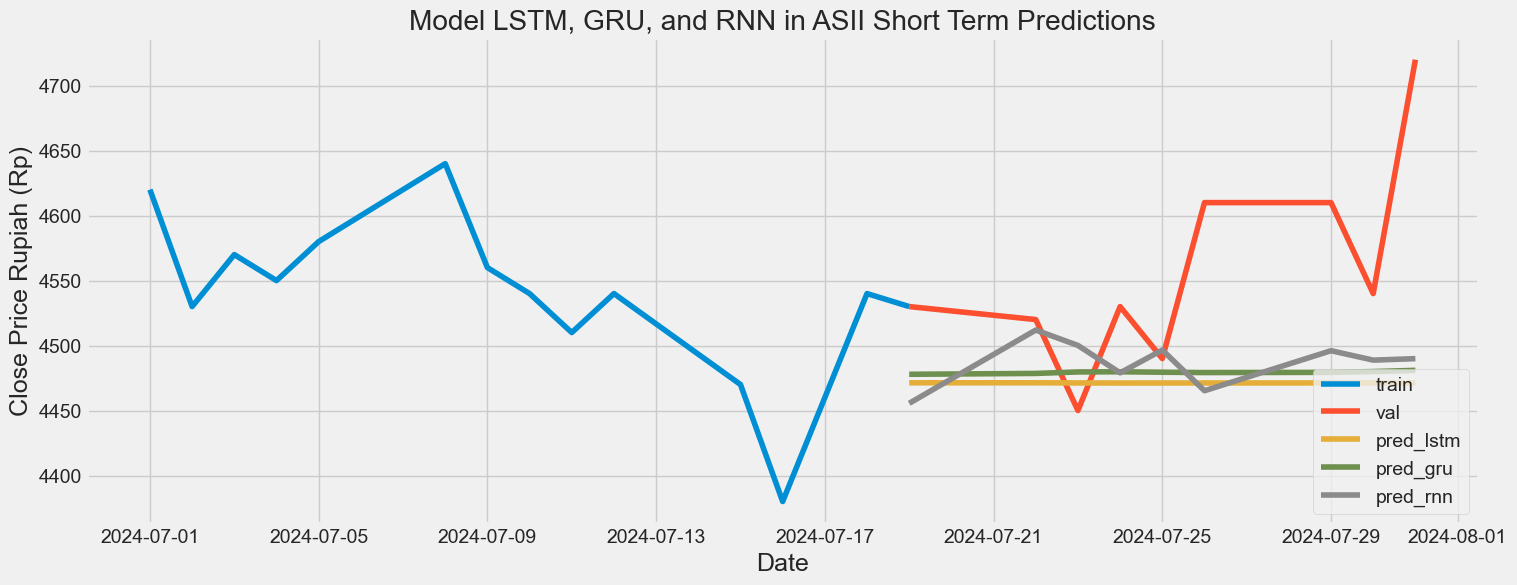

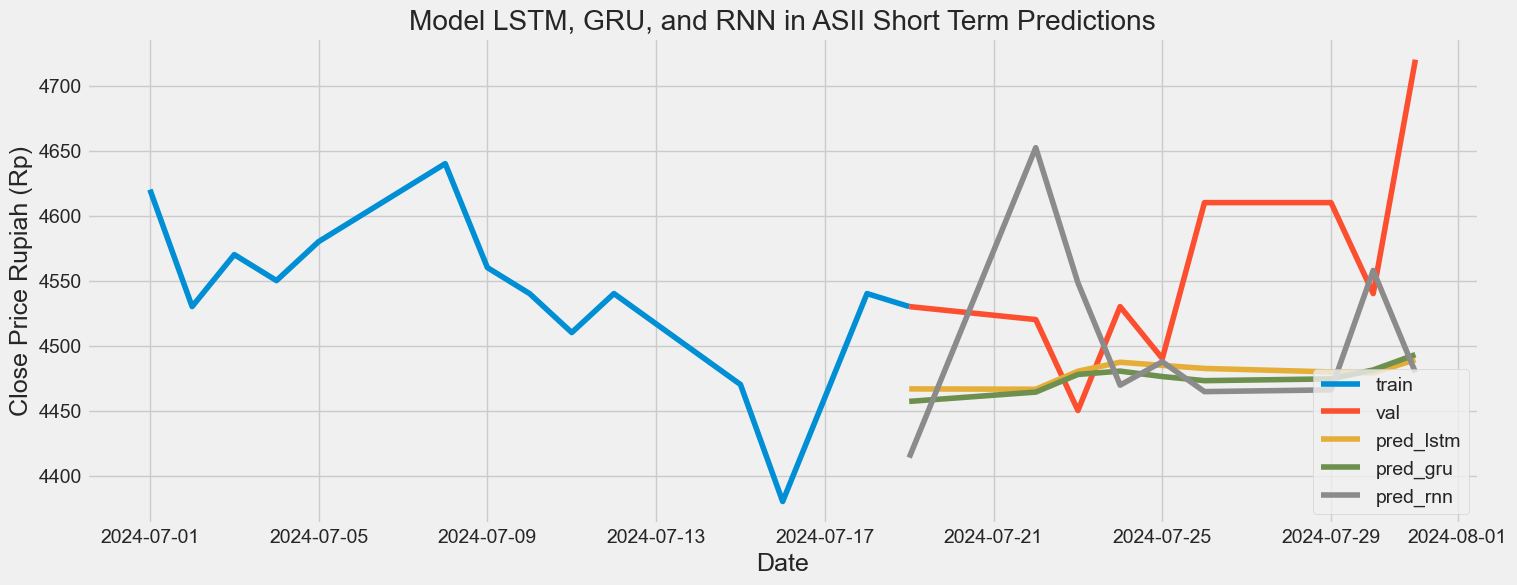

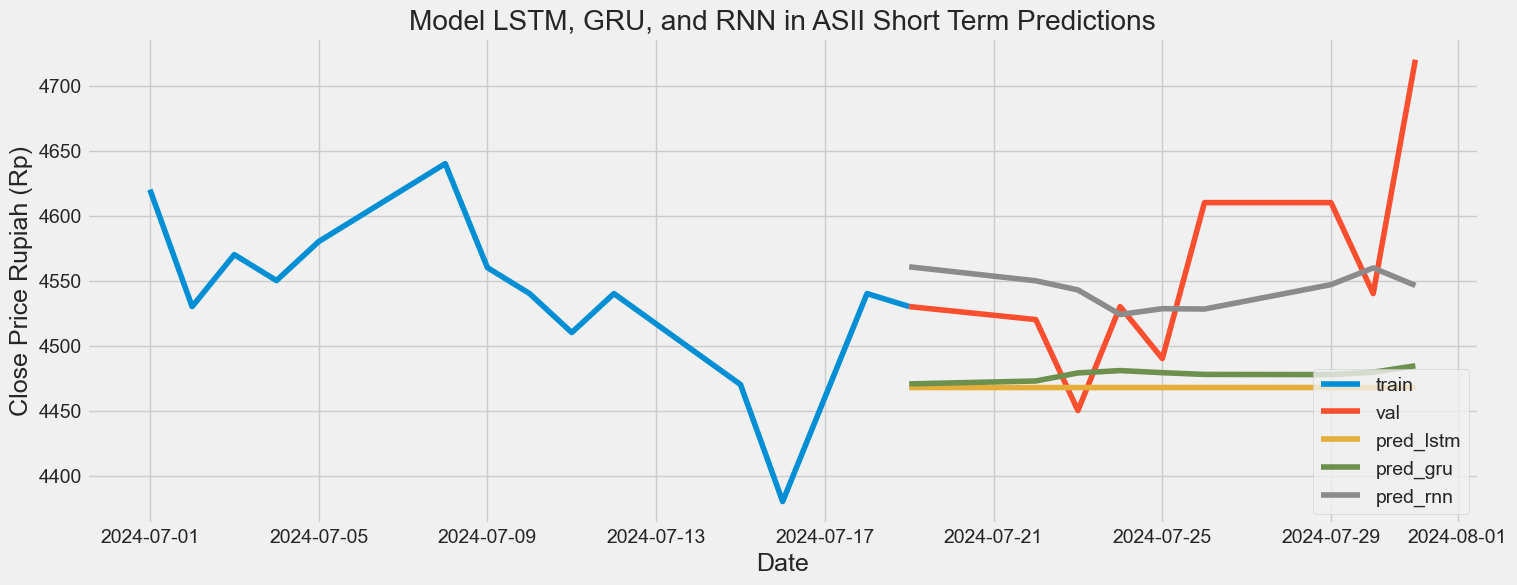

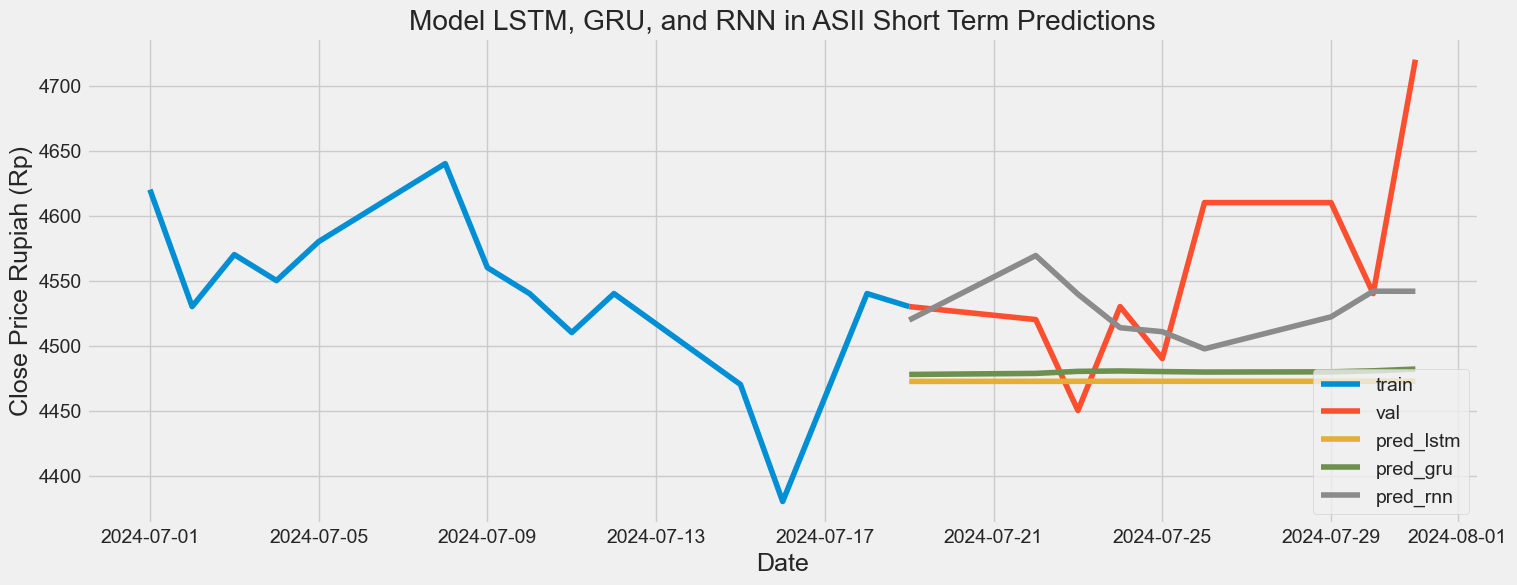

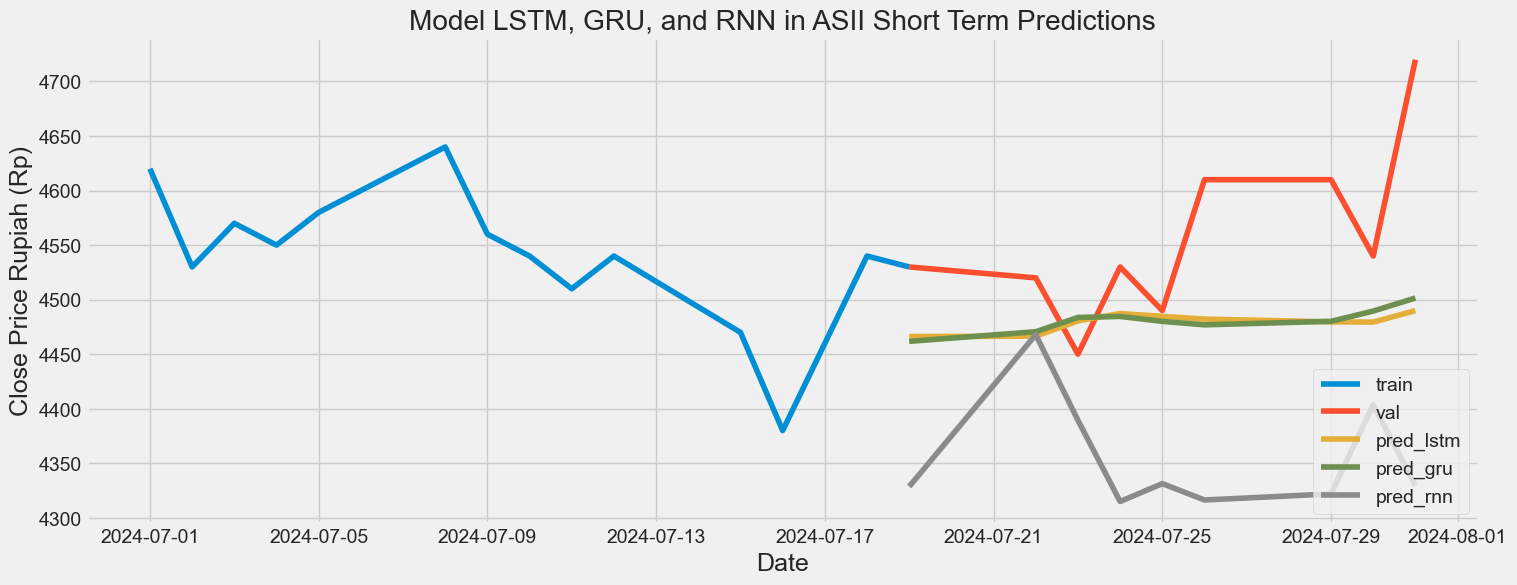

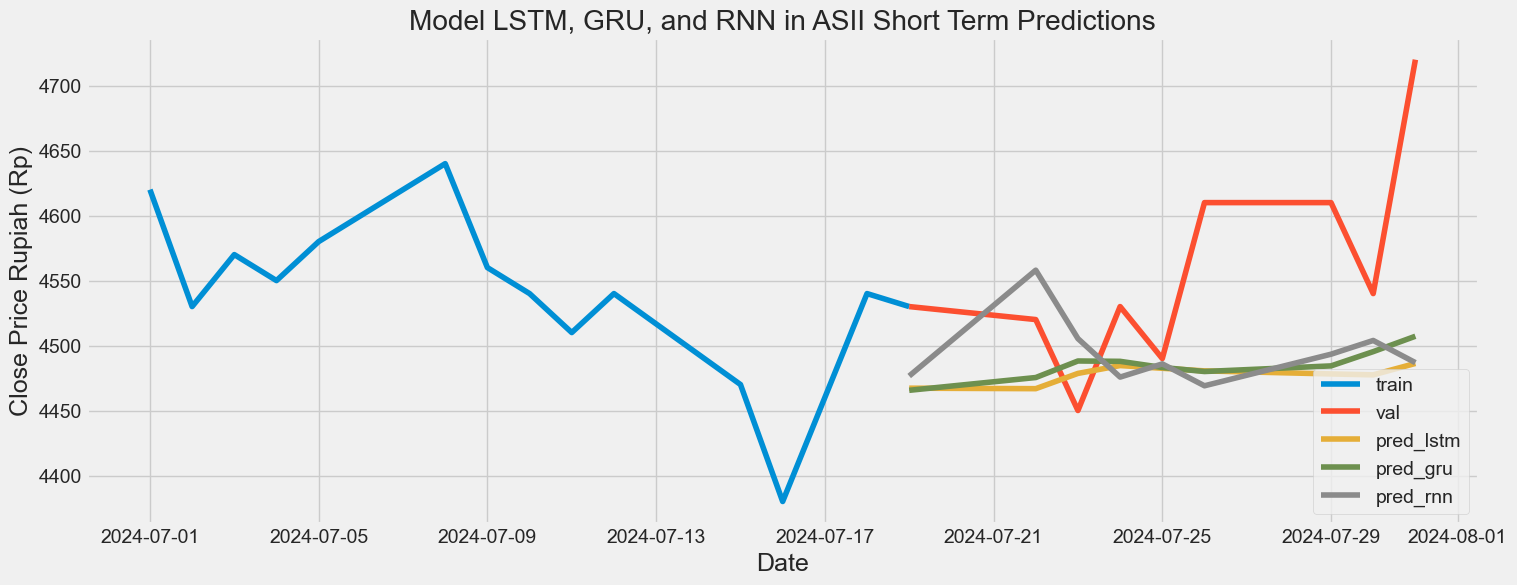

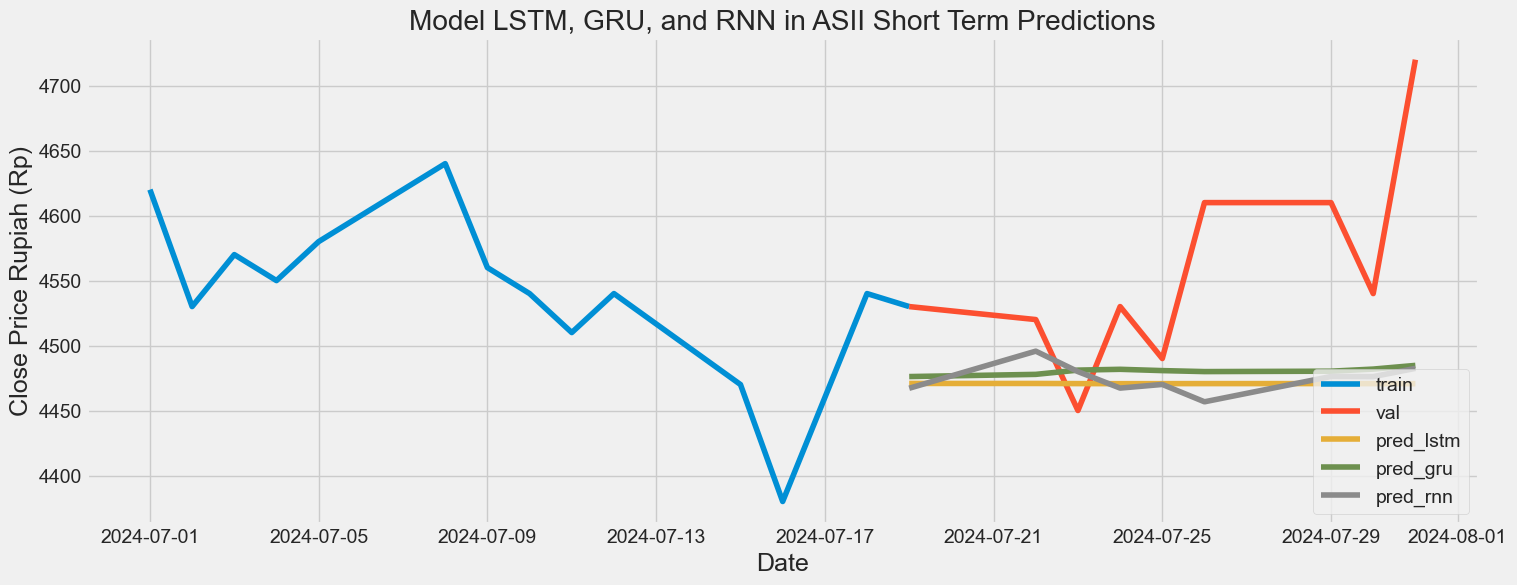

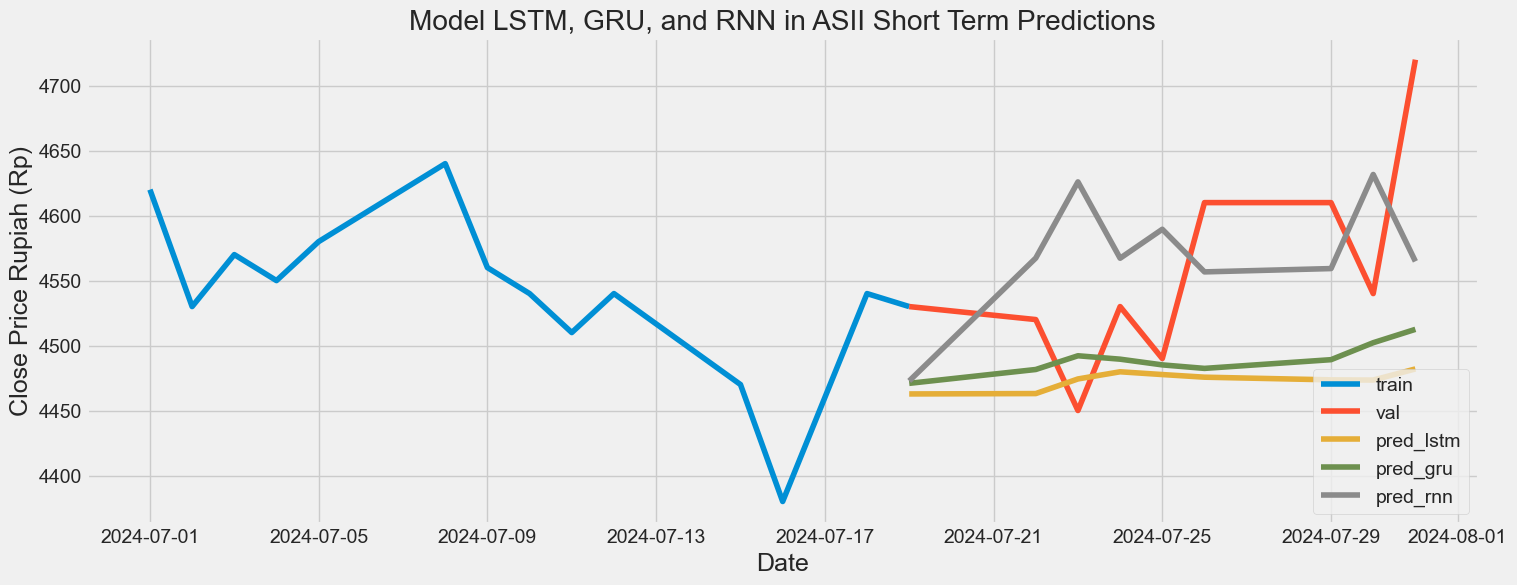

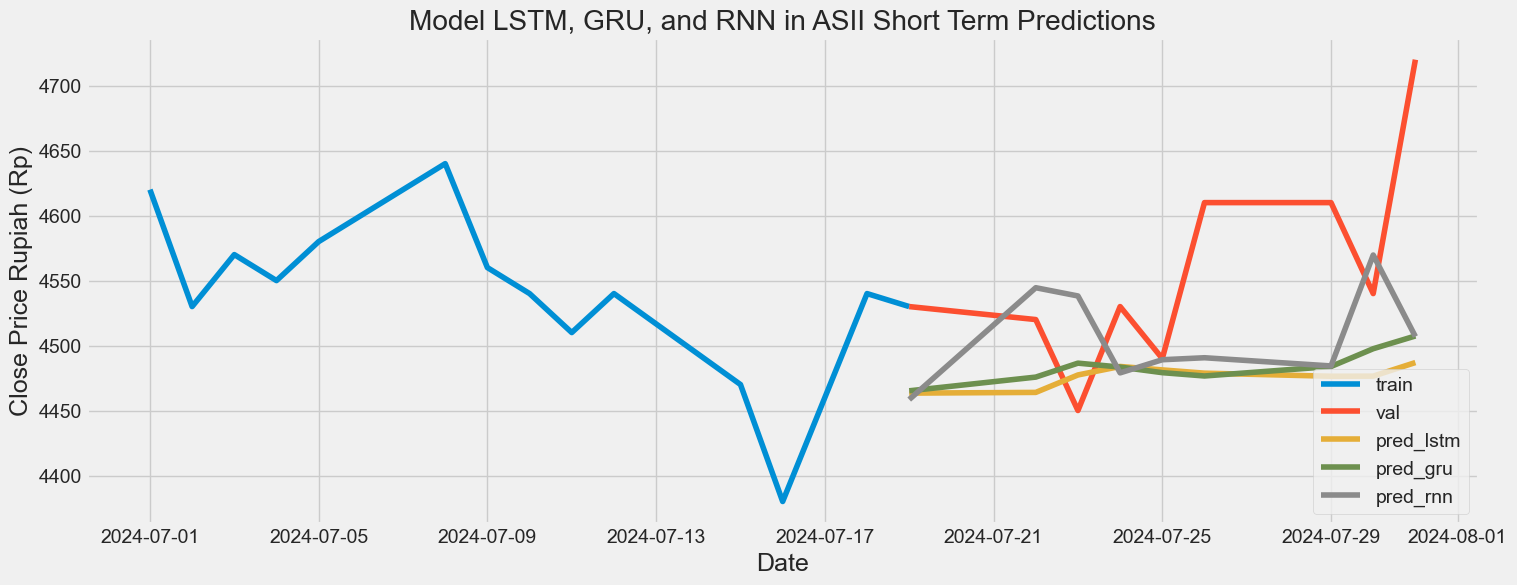

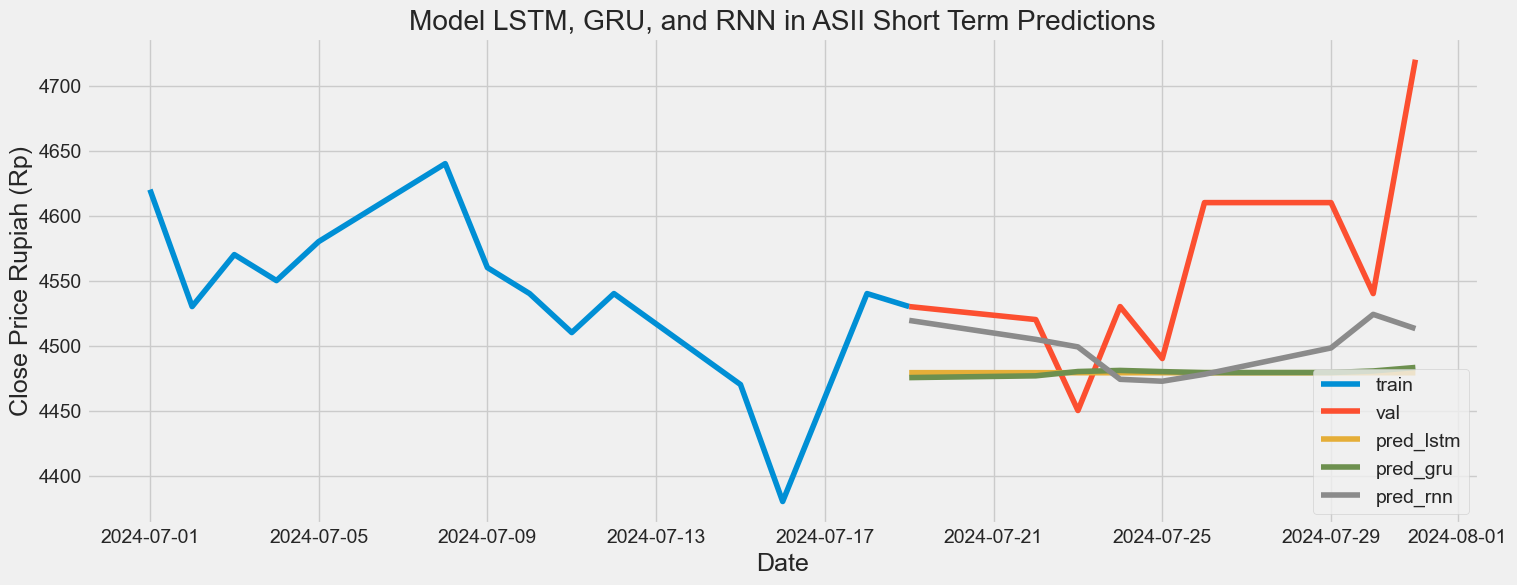

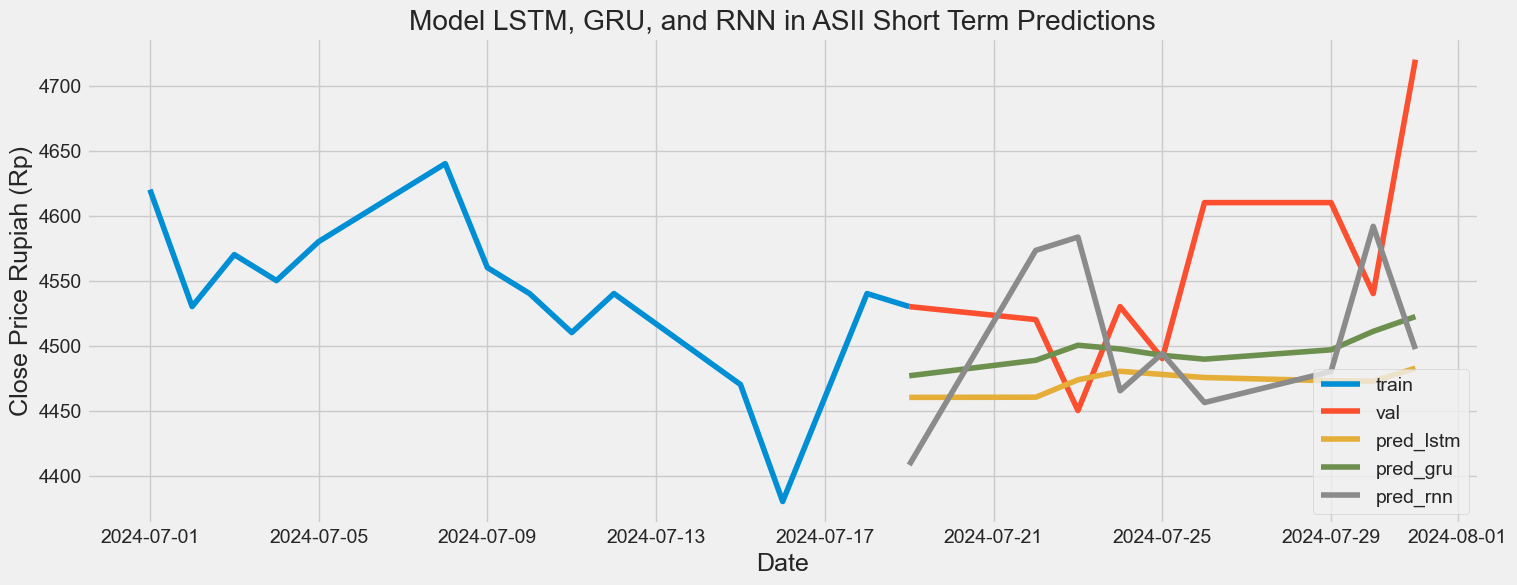

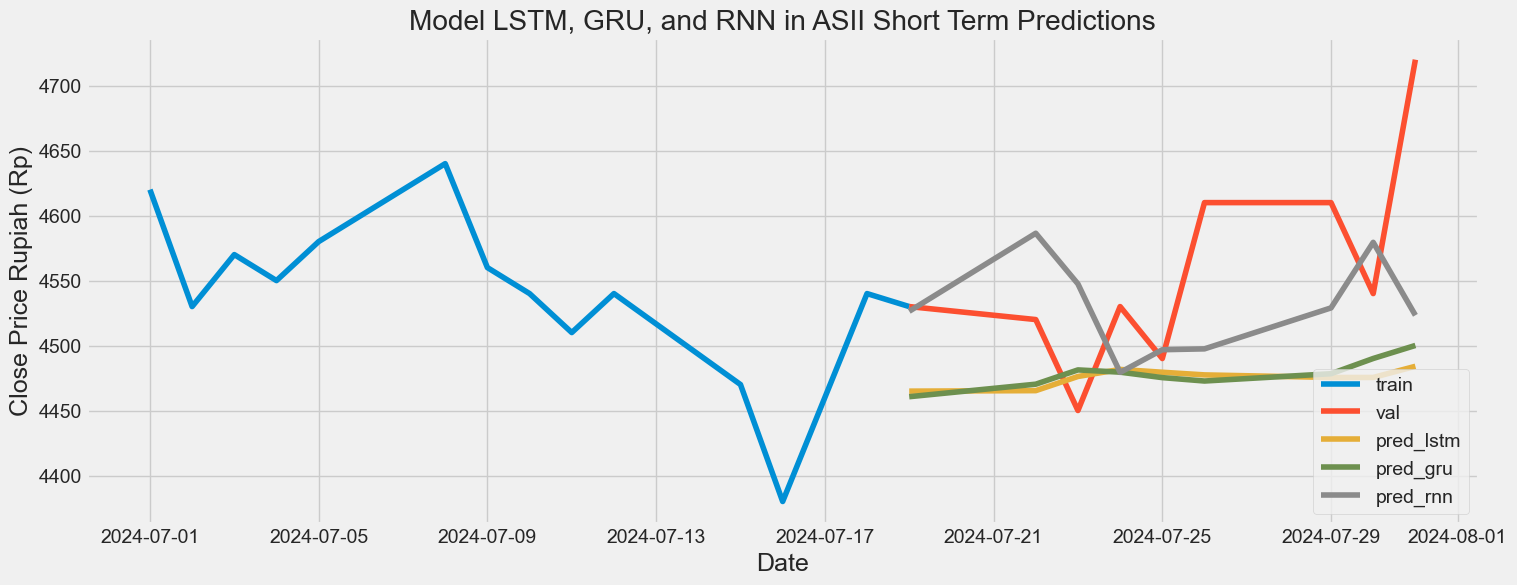

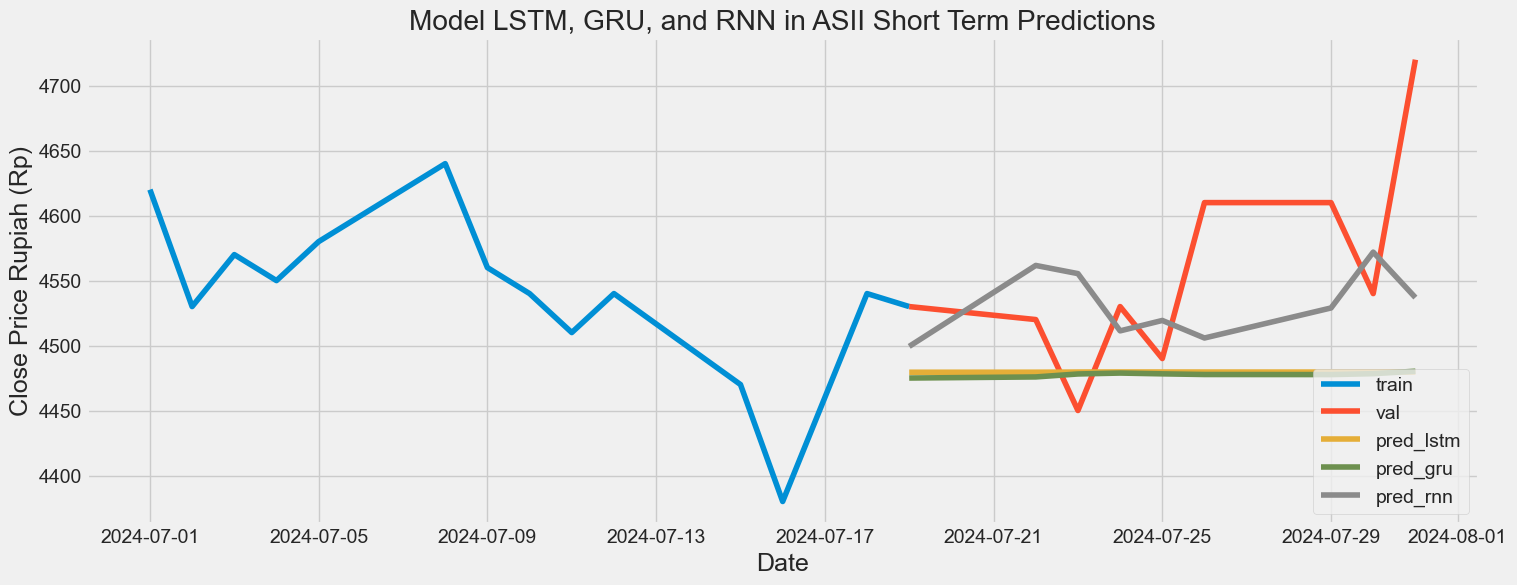

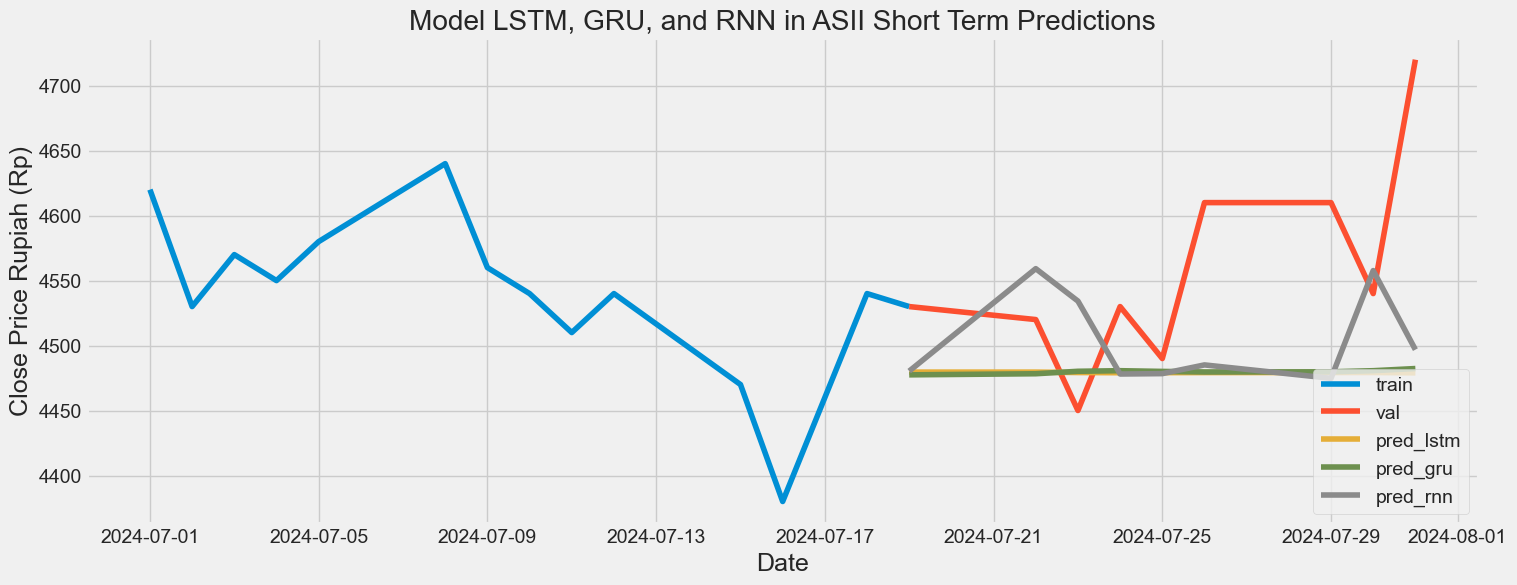

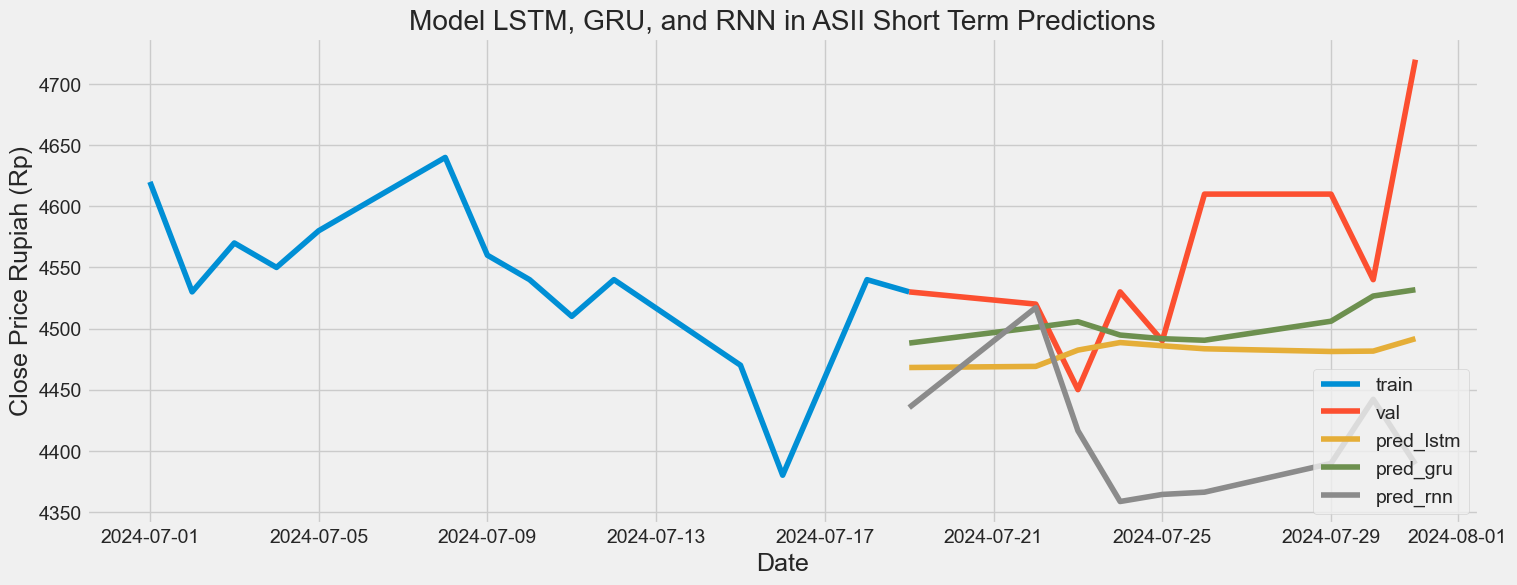

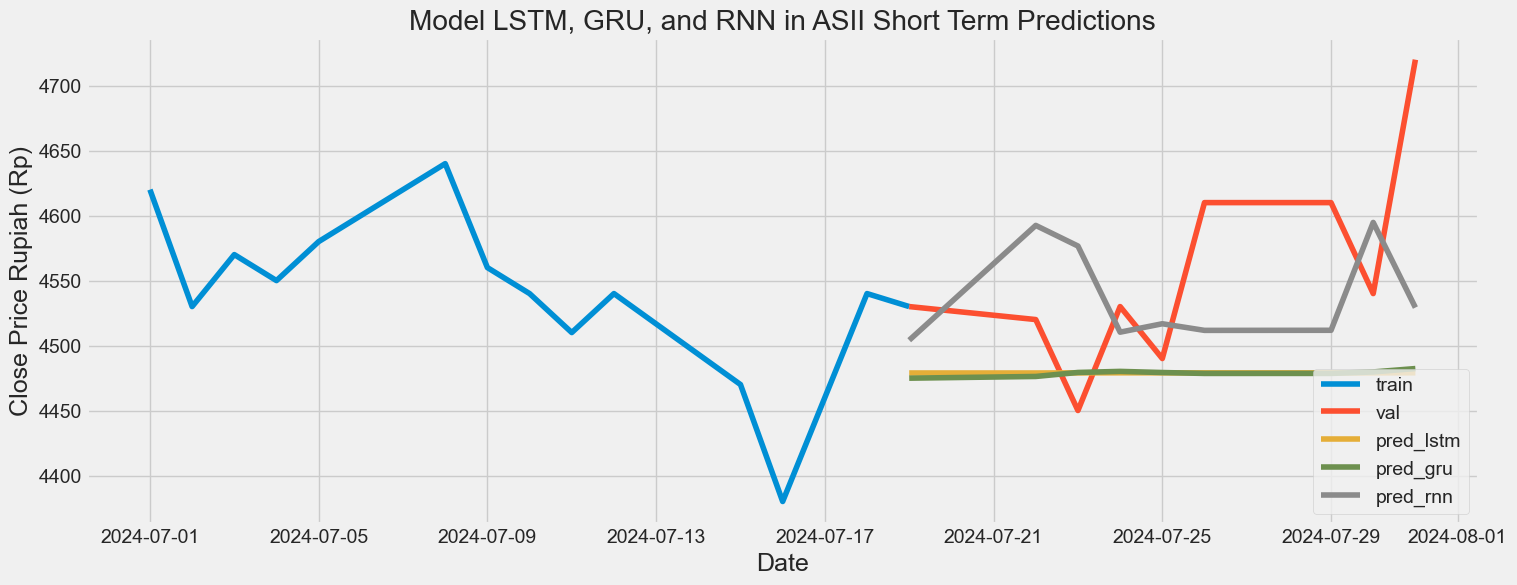

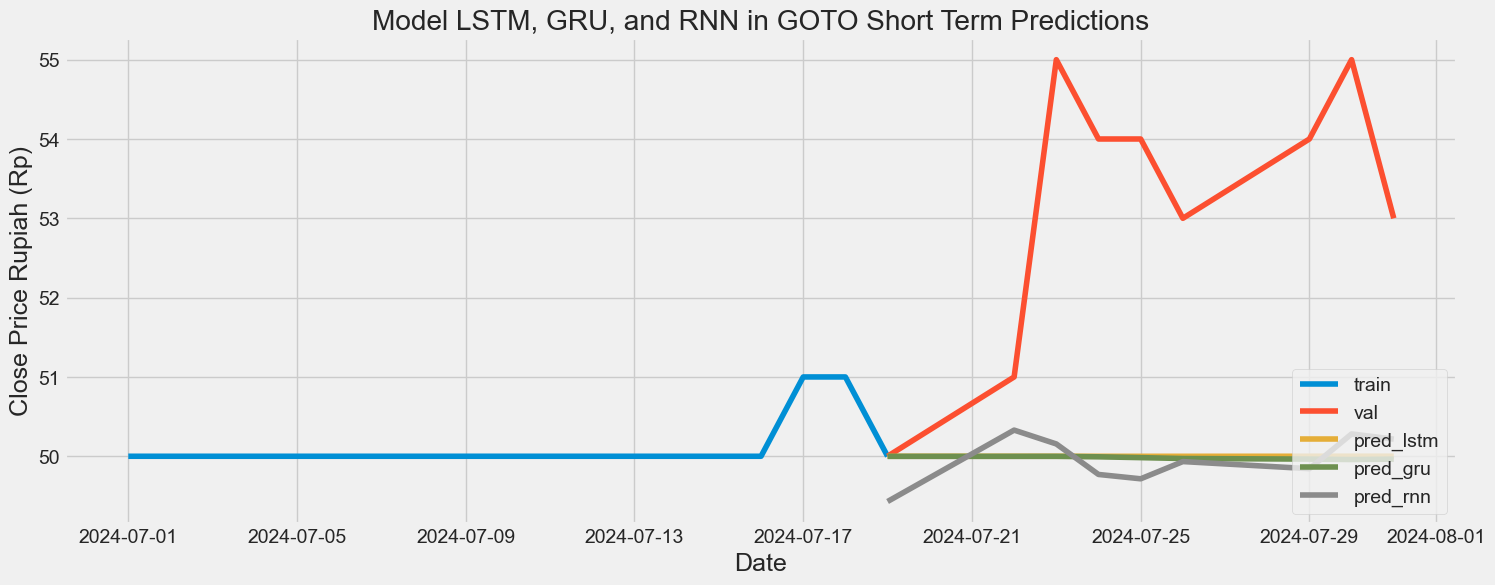

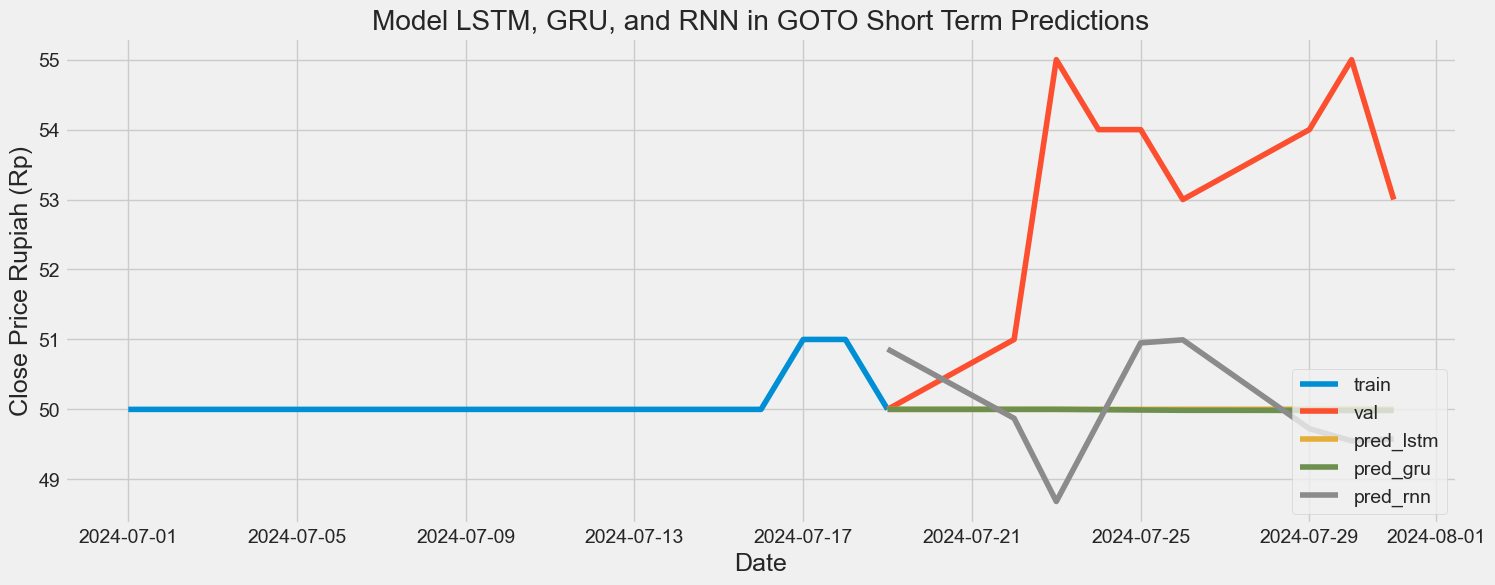

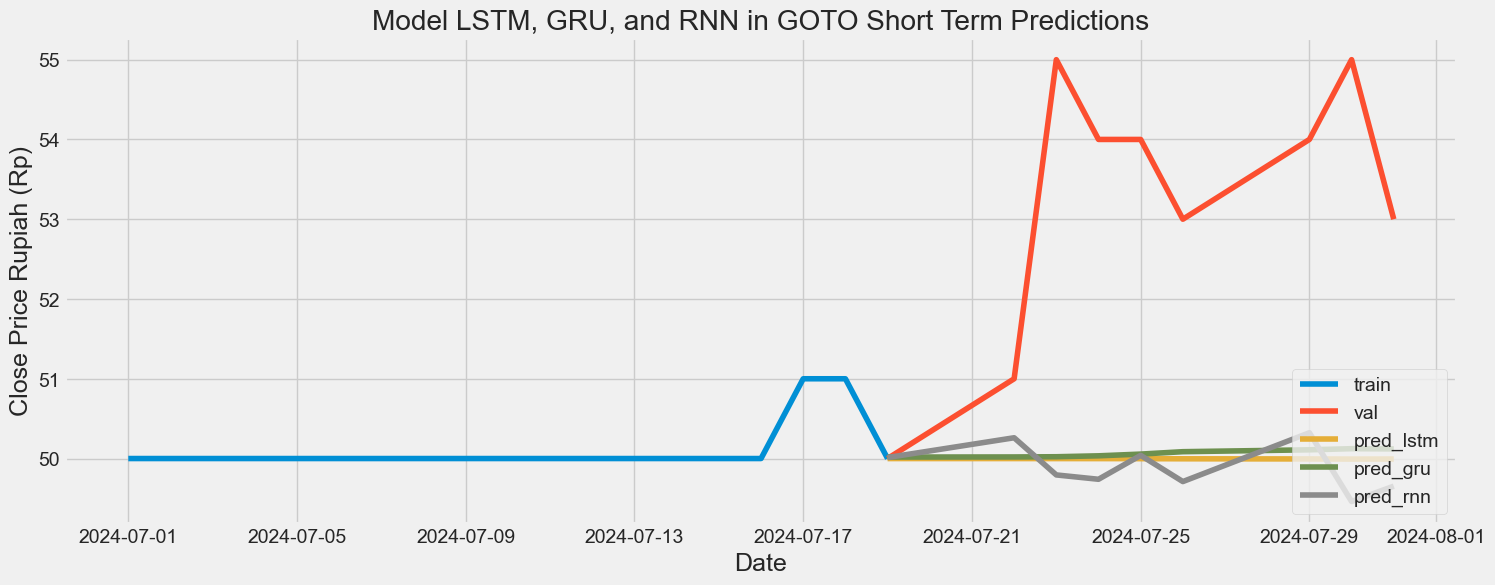

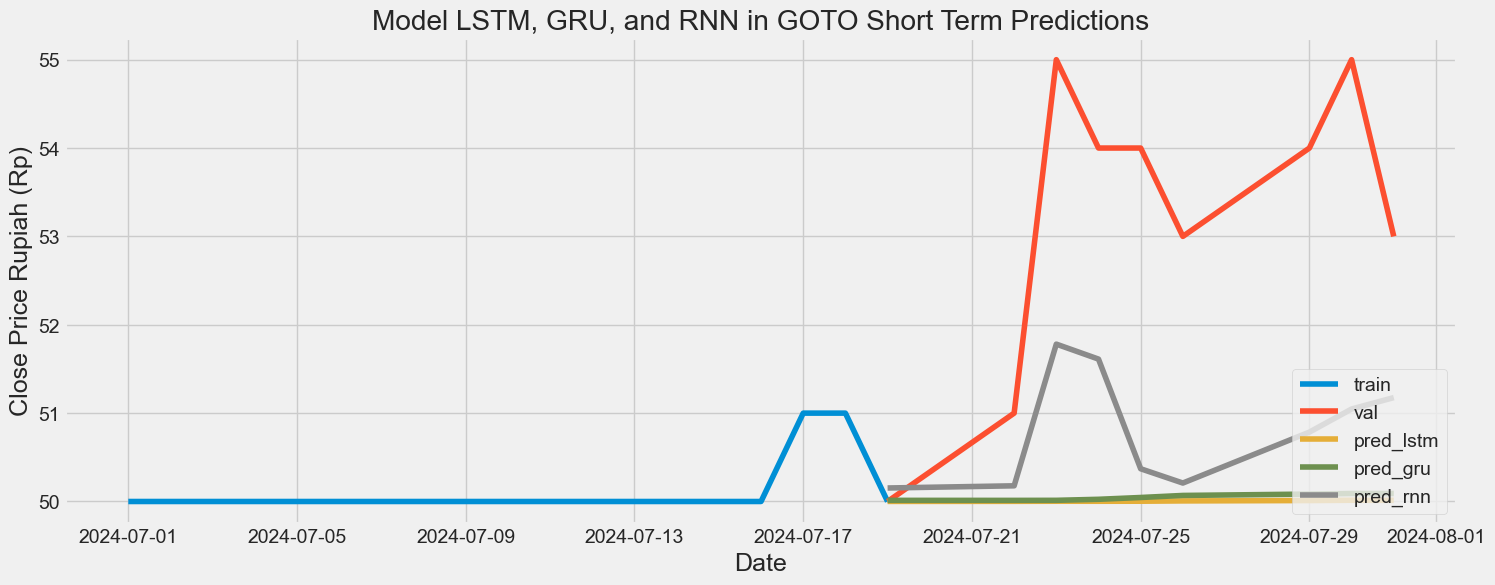

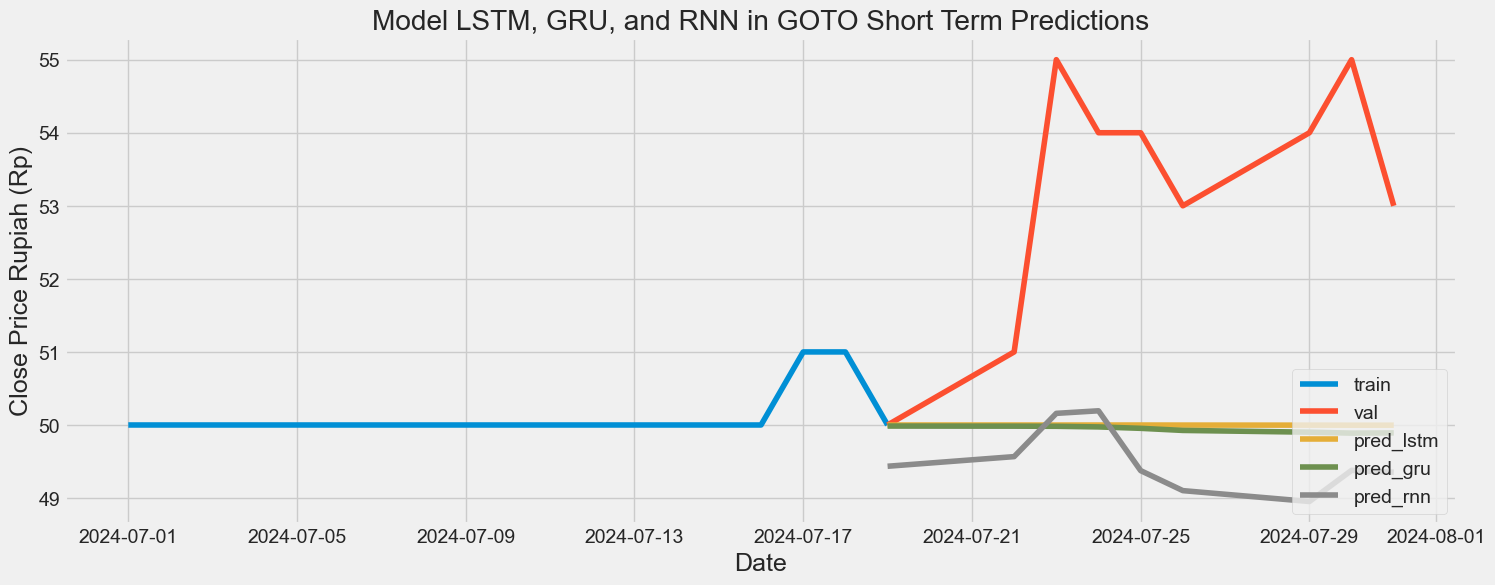

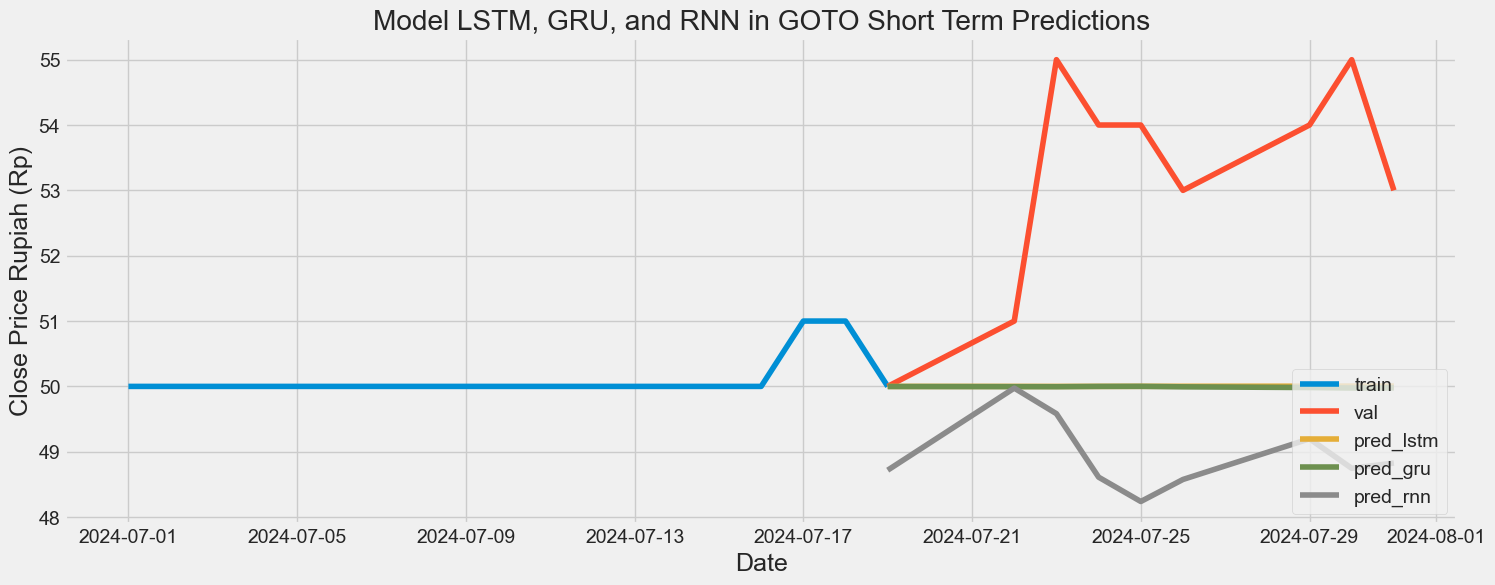

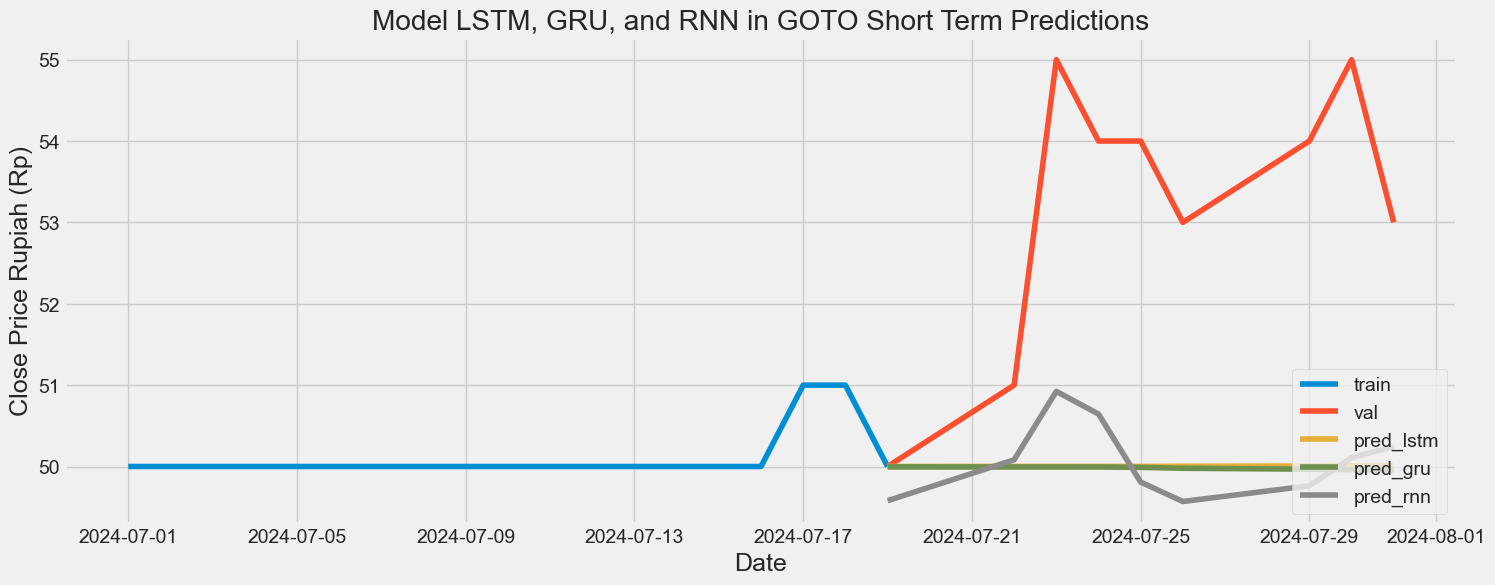

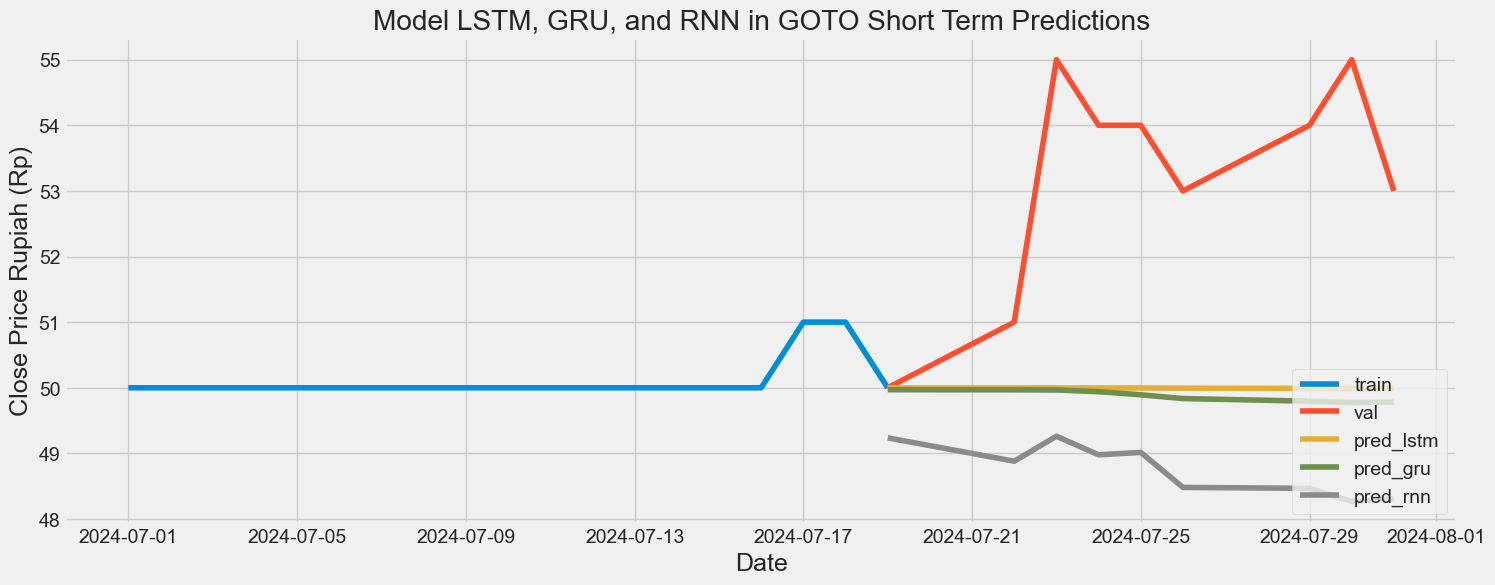

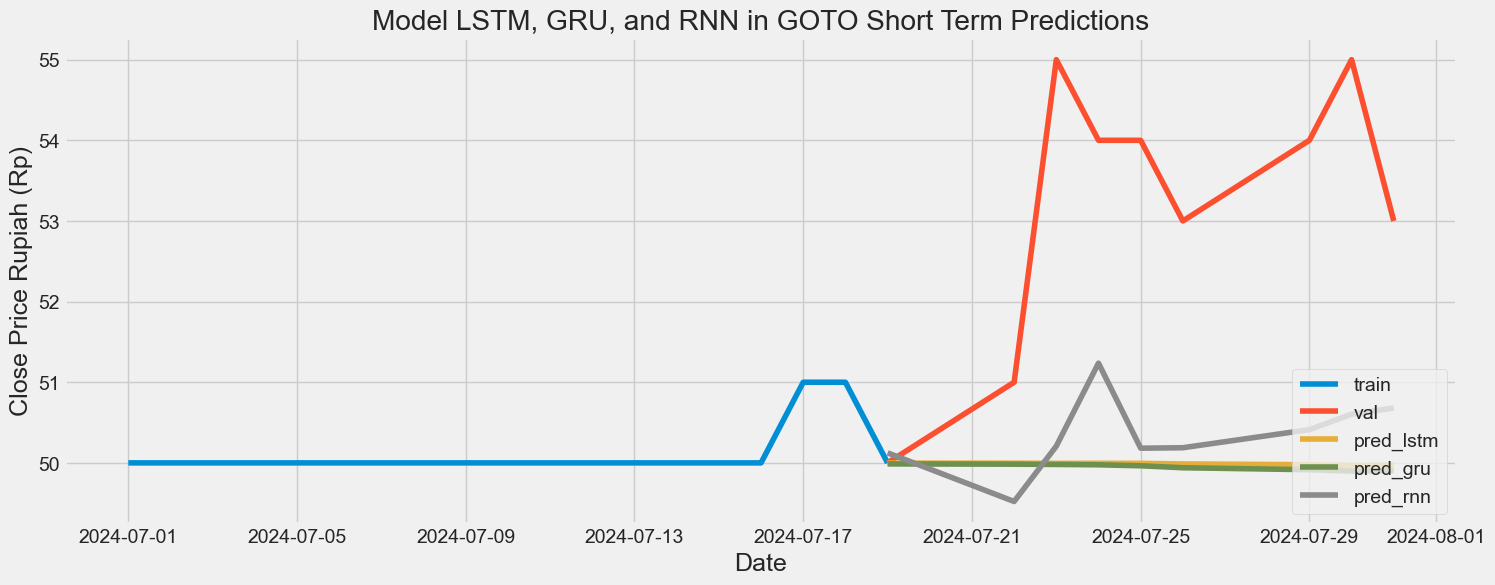

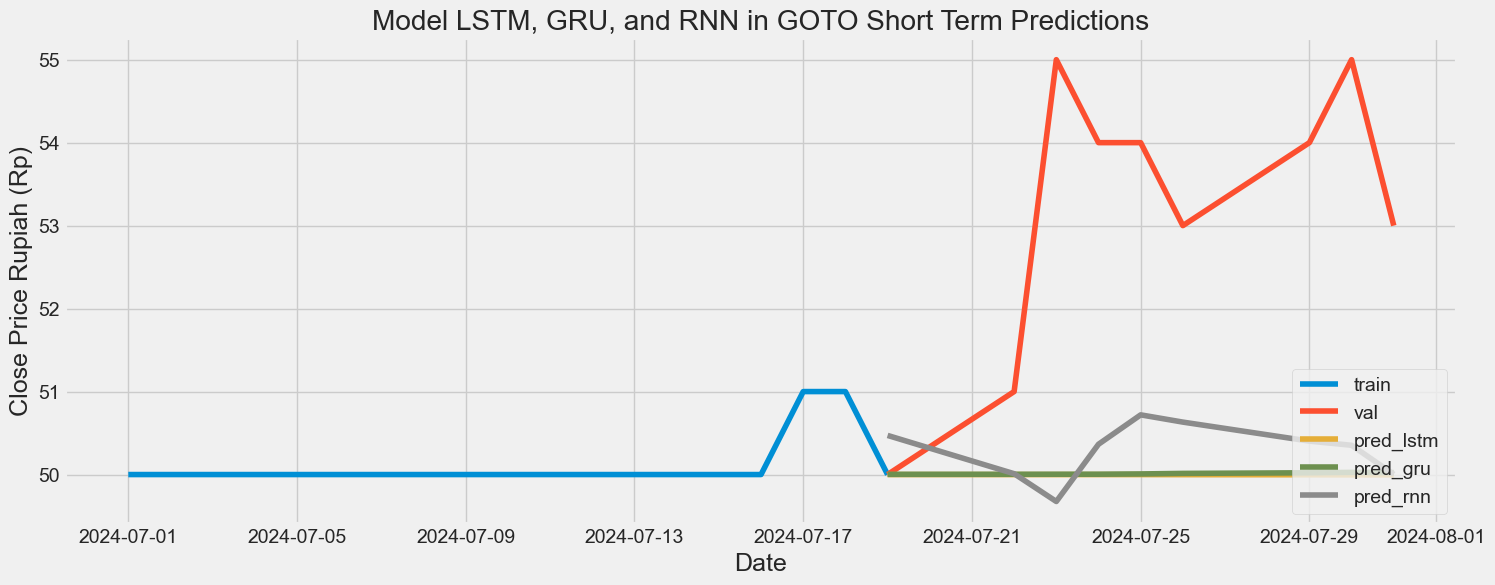

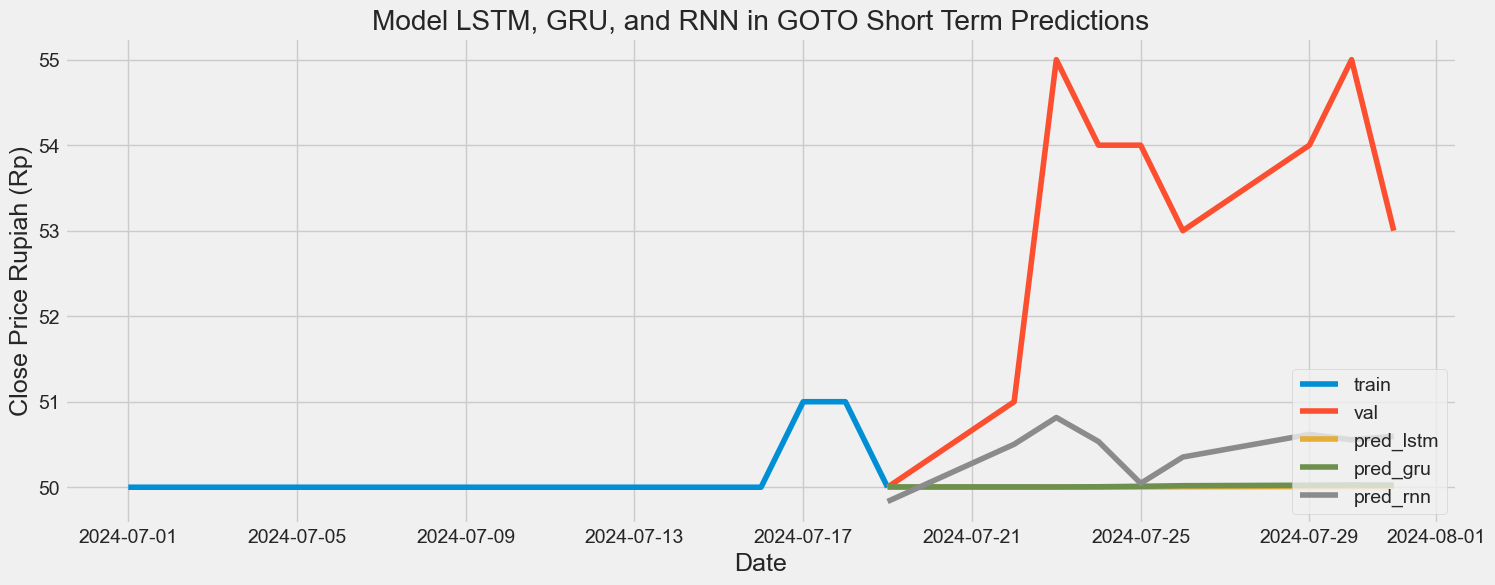

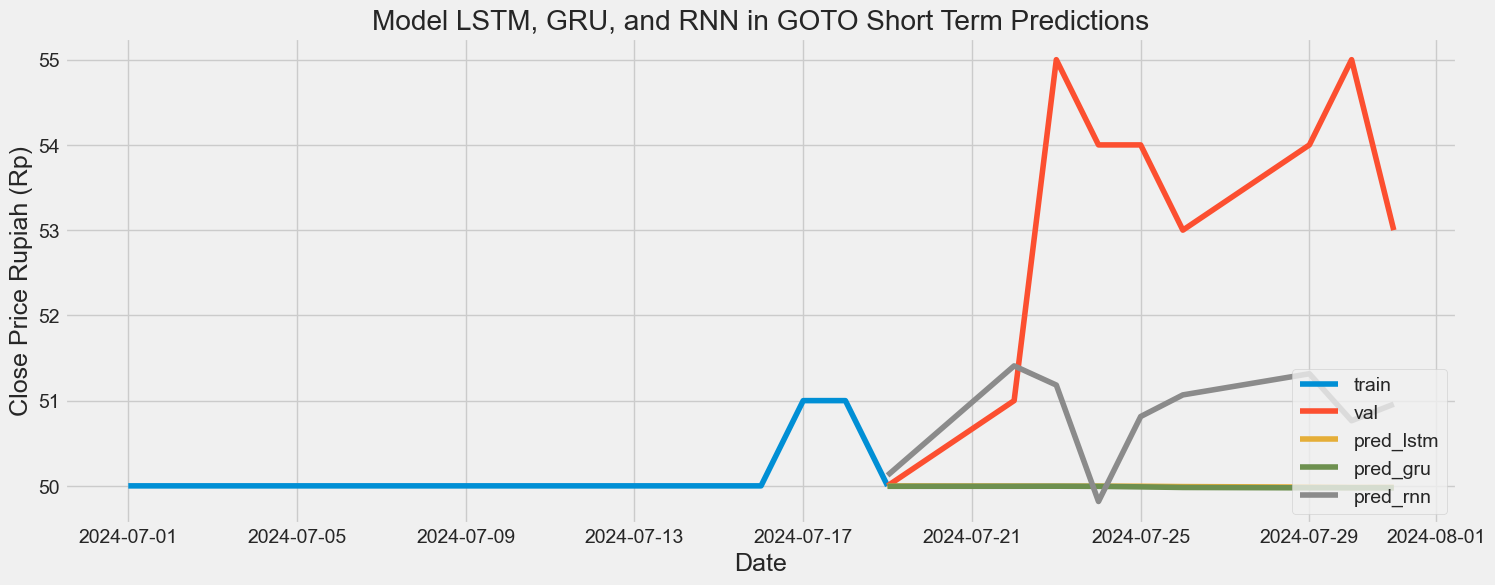

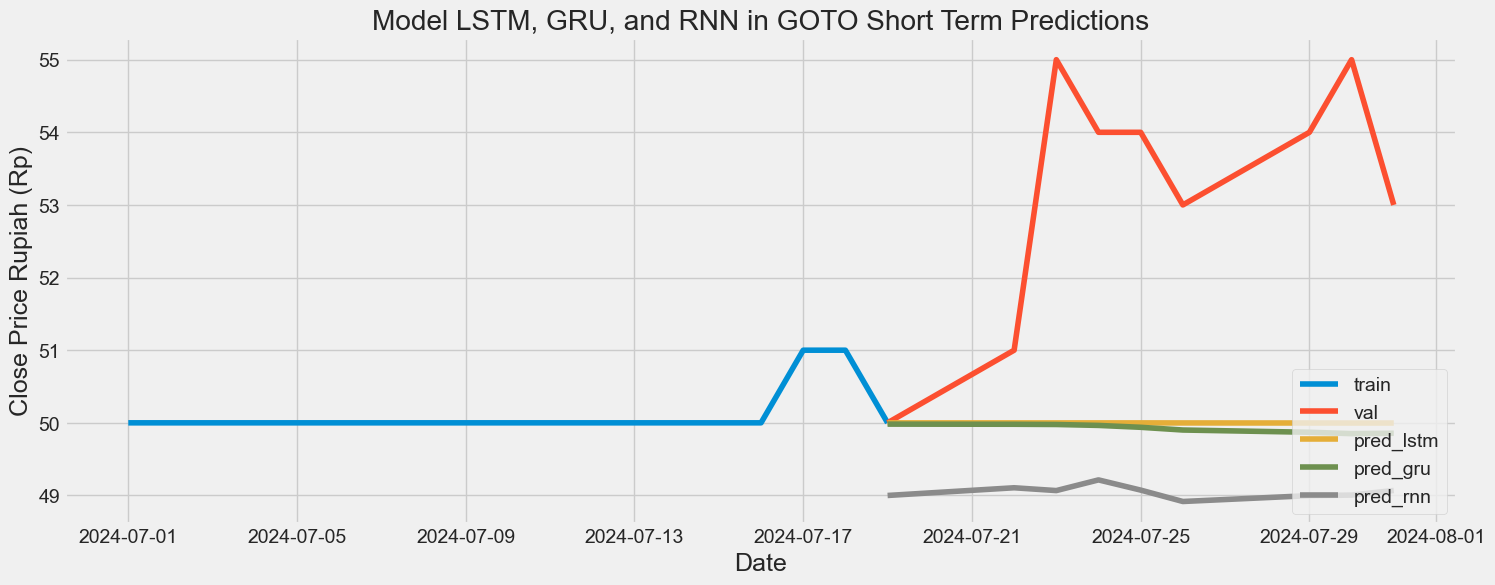

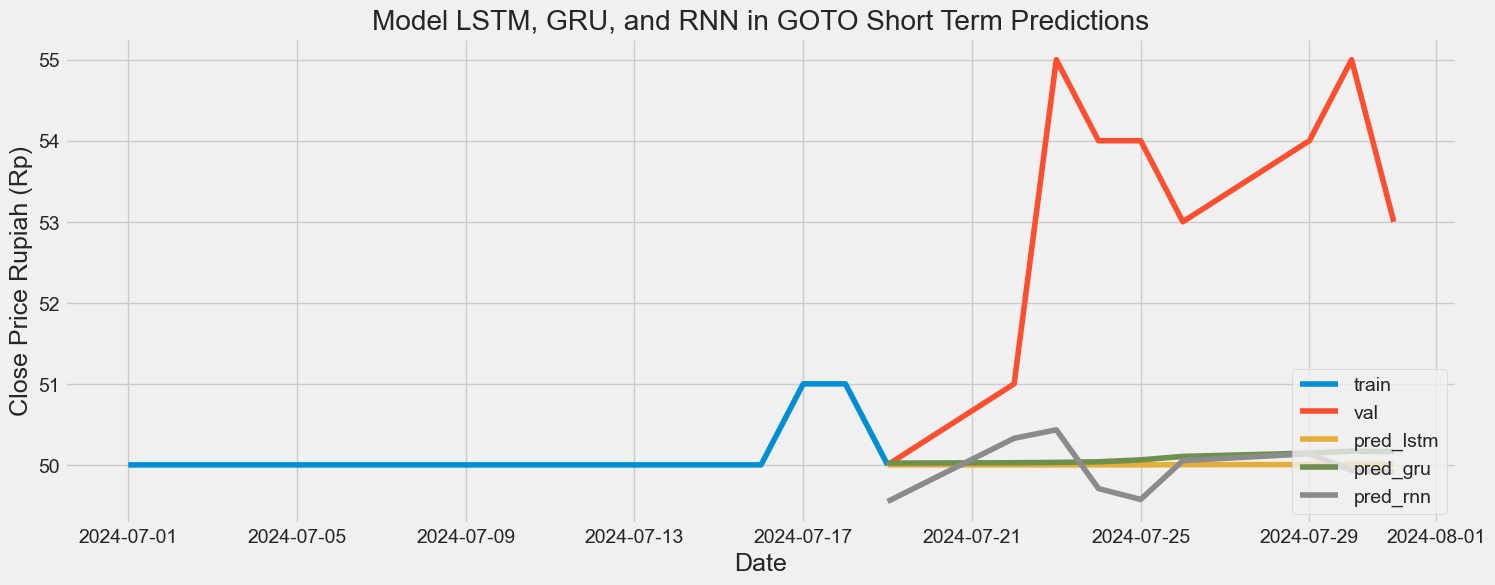

In [24]:
stock_name = ['ASII', 'GOTO']
try_epoch = [50, 100]
try_batch = [32, 64]
try_unit = [50, 100]
try_optimizer = ['rmsprop', 'adam', 'sgd']
for n_name in stock_name:
    if n_name == 'GOTO':
        n_data = GOTO
    elif n_name == 'ASII':
        n_data = ASII
    for n_epoch in try_epoch:
        for n_unit in try_unit:
            for n_batch_size in try_batch:
                for n_optimizer in try_optimizer:
                    train_short(n_data, n_name, start_date, med_date, end_date, n_epoch, n_unit, n_batch_size, n_optimizer)
                

In [ ]:
dic_res_tuning

{'stock': 'ASII',
 'term': 'short',
 'algorithm': 'GRU',
 'rmse': 51.705793371379244,
 'rmse_norm': 0.3693270955098525,
 'epoch': 50,
 'unit': [],
 'optimizer': 'adam',
 'batch_size': 32,
 'units': 50}

#### Long Term Predcitions

In [ ]:
stock_name = ['ASII', 'GOTO']
try_epoch = [50, 100]
try_batch = [32, 64]
try_unit = [50, 100]
try_optimizer = ['rmsprop', 'adam', 'sgd']
for n_name in stock_name:
    if n_name == 'GOTO':
        n_data = GOTO
    elif n_name == 'ASII':
        n_data = ASII
    for n_epoch in try_epoch:
        for n_unit in try_unit:
            for n_batch_size in try_batch:
                for n_optimizer in try_optimizer:
                    train_long(n_data, n_name, year, n_epoch, n_unit, n_batch_size, n_optimizer)
                